**Execute the below cell directly – might take ~1min to import everything!**

In [ ]:
%%time
import pickle, uproot
import pandas as pd
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
mpl.rcParams.update({'font.size': 20})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

# Intro: NN topological trigger for L1

See the recent Deep Dive for an overview of the concepts and current studies of ML triggers at L1:
* AXOL1TL: anomaly trigger in the uGT: https://indico.cern.ch/event/1342837/#34-axol1tl-event-level-anomaly
* CICADA: anomaly trigger using L1 Calorimeter tower images: https://indico.cern.ch/event/1342837/#35-cicada
* TOPO: ML topo classifier in the uGT: https://indico.cern.ch/event/1342837/#33-topo-ml-based-topology-trig

The goal of this part of the ML@L1 tutorial is to get you familiarised with the Run3 L1 Global Trigger (uGT) data and learn how to use it to train a ML trigger for signal vs background classification -> the TOPO approach from above.

This part1 of the tutorial consists of the following steps:

1. Load L1 data from NanoAOD files and preprocess them for ML usage
2. Train and evaluate an NN classifier
3. Check the signal efficiency & rate of "traditional" L1 seeds (the menu)
4. Compare the NN trigger to the L1 menu
5. Measure efficiencies wrt some offline object variables

For an intro to the CMS NanoAOD dataformat and it's usage for trigger-related measurements, see the recent PO&DAS tutorial here: https://gitlab.cern.ch/cms-podas23/dpg/trigger-exercise

# 1. Load L1 objects data and plot variables for sig vs bkg

We will be using samples from the same Run3Summer22 MC campaign for this tutorial:
* HH>2b2tau as signal (`/GluGlutoHHto2B2Tau_kl-1p00_..._TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22...`)
* SingleNu gun as background (`/SingleNeutrino_E-10_gun/Run3Summer22MiniAODv4-SNB_130X_mcRun3_2022_..`)

Note that the single neutrino gun is the MC equivalent of the `ZeroBias` data, but we will be using only MC for easier comparisons (e.g. the same PU profile and L1 calibrations).

Below are the data paths to the NanoAOD files with the L1 objects added:

In [2]:
fname_sig = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/run3/L1nano/ggHH2b2tau_130x_v12.root"
fname_bkg = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/run3/L1nano/v12/mc/SingleNeutrino_E-10_gun/SingleNeutrino_130X_L1NanoV12_None/231205_110830/SingleNeutrino_130X_L1NanoV12.root"

We will be using [`uproot`](https://uproot.readthedocs.io/en/latest/index.html) and [`awkward arrays`](https://awkward-array.org/doc/main/) for reading the Nano ROOT files and manipulating the "jagged" arrays.

(see the above linked PO/DAS tutorial for more intro material)

In [3]:
f_sig = uproot.open(fname_sig)
f_bkg = uproot.open(fname_bkg)

We will be reading the L1 collections of:
* `L1Mu`: muons
* `L1EG`: e/gamma
* `L1Jet`: jets
* `L1EtSum`: sums such as MET, HT

For all we want to get the `pt`, `phi` and `eta` (except for sums), and in addition the sum type (usage will be explained below).

See the [nano auto-doc](https://cms-nanoaod-integration.web.cern.ch/autoDoc/NanoAODv12/2023Prompt/doc_EGamma0_Run2023C-PromptNanoAODv12_v2-v2.html) for more information.

Below we will load the information using the `array` method of `awkward`. It accepts regexp for the branch name filter.

In [4]:
%%time
data_sig = f_sig["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(pt|eta|phi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

CPU times: user 1.87 s, sys: 48.9 ms, total: 1.92 s
Wall time: 1.92 s


Note how each object is grouped in a respective field:

In [5]:
data_sig.fields

['L1EG', 'L1EtSum', 'L1Jet', 'L1Mu']

And the variables are accesible at the next level (this is a result of using `how="zip"` when loading)

In [6]:
data_sig.L1EG.fields

['eta', 'phi', 'pt']

In [7]:
%%time
data_bkg = f_bkg["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(pt|eta|phi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

CPU times: user 3.85 s, sys: 155 ms, total: 4 s
Wall time: 4.01 s


In [8]:
data_bkg.L1EG.pt

<Array [[], [2.5], ..., [...], [2.5, 2.5, 2.5]] type='947200 * var * float32'>

### Important: in DATA one has to only filter on `bx=0` for proper usage!
Below is an example of how this can be achieved:

We shall filter the `bx=0` L1 objects from the events -> need to add `bx` to the array reading step above.

```python
data_bkg_allBX = data_bkg

bx = 0
data_bkg_bx0 = {}

for obj in data_bkg_allBX.fields:
    # make a mask to filter out bx=0 only
    bx_mask = data_bkg_allBX[obj].bx == bx
    data_bkg_bx0[obj] = data_bkg_allBX[obj][bx_mask]
    
data_bkg = ak.Array(data_bkg_bx0)
```

## Inspect input data / plot distributions

First, let's inspect the variables we are going to use. 

We will start with the object multiplicities:

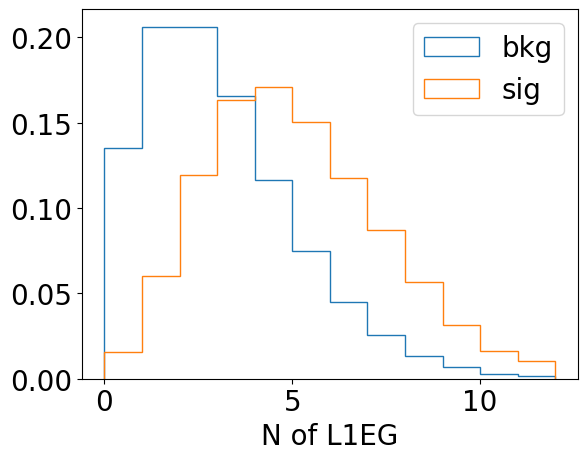

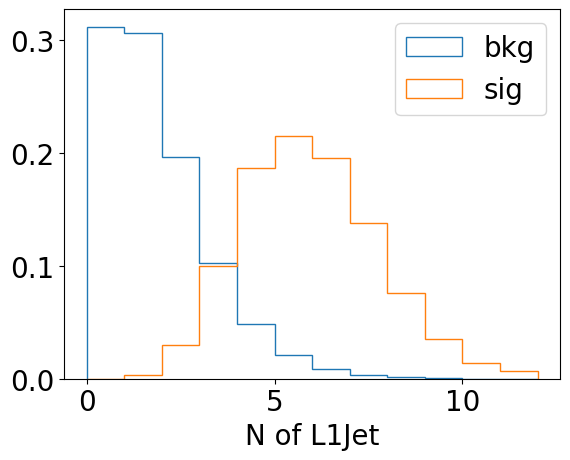

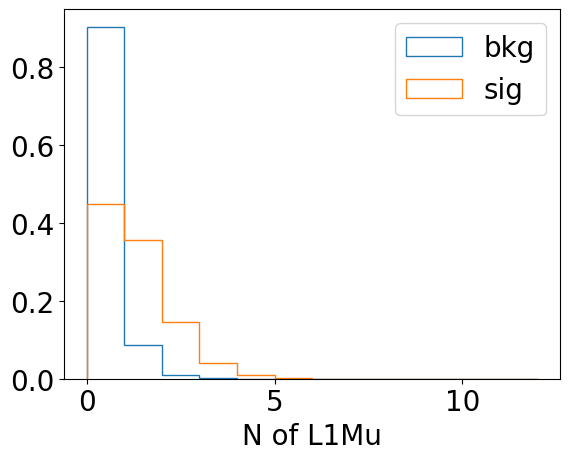

In [9]:
for obj in [ 'L1EG', 'L1Jet', 'L1Mu']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj])
        plt.hist(num, label = label, bins = range(13), density = True, 
                 #log = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()
#     plt.grid()

Let us also plot the pt of the leading object:

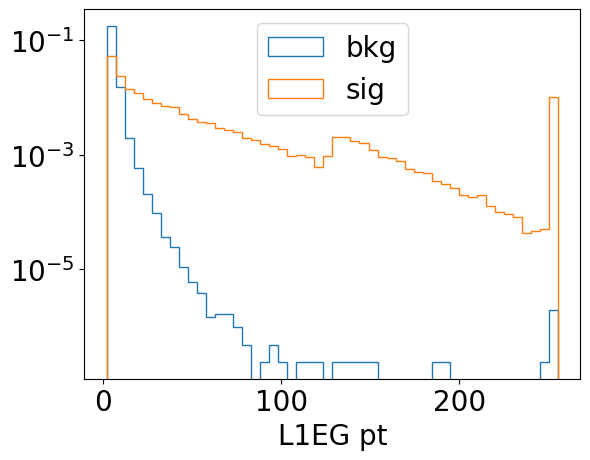

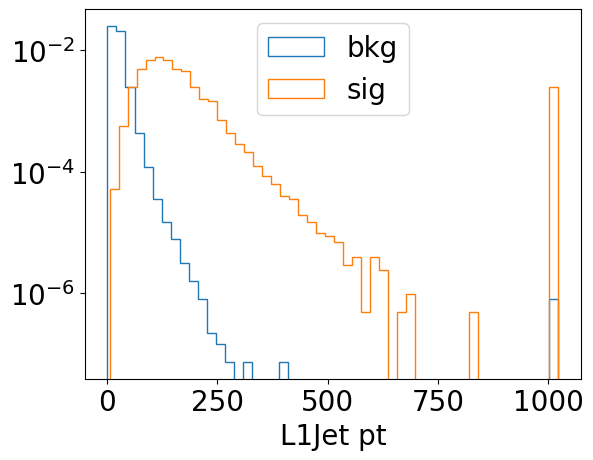

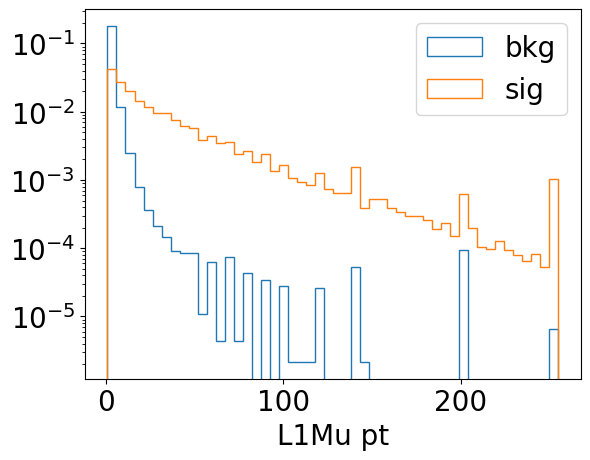

In [10]:
for obj in [ 'L1EG', 'L1Jet', 'L1Mu']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # notice the [:,:1] below -> we slice the array and select no more than the first entry per event
        # ak.ravel makes the array flat such that we can fill a histogram
        plt.hist(ak.ravel(data[obj].pt[:,:1]), label = label, bins = 50, density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} pt")
    plt.legend()
#     plt.grid()

There surely is some discrimation power in these variables! :)

Let's move over to the ML part, though we first need to preprocess the data / convert it into a flat format

### Convert data to regular array for ML usage

Due to the variable number of objects per event (except for the sums) we need to convert the data from the jagged format to a tabular (regular) format with the rows corresponding to events and the columns to the variables. 

For that we have to pick:
1. An order of objects e.g. Sums, Jets, EG, Muons
2. The variables for each
3. The max number of objects we want to use
4. The values to use to pad empty objects

We can write this down in the following dictionary:

In [11]:
objects = [
    {"name" : "MET", "key" : "L1EtSum", "fields" : ["pt", "phi"], "n_obj" : 1,
     "cuts" : [{"cuttype" : "equals", "field" : "etSumType", "value" : 2}] },  # etSumType 2 = MET noHF
    {"name" : "jet", "key" : "L1Jet", "fields" : ["pt", "eta", "phi"], "n_obj" : 8},
    {"name" : "eg", "key" : "L1EG", "fields" : ["pt", "eta", "phi"], "n_obj" : 8},
    {"name" : "muon", "key" : "L1Mu", "fields" : ["pt", "eta", "phi"], "n_obj" : 2},
]

Note that for getting L1MET from the sum collection we need to filter based on the `sumType`. 
`etSumType==2` corresponds to MET (w/o HF) as can be checked in the corresponding CMSSW dataformat:
https://github.com/cms-sw/cmssw/blob/master/DataFormats/L1Trigger/interface/EtSum.h#L36

_(note though that normally METHF/ETMHF is used for MET triggers -> `type==8`)_

We will use dedicated functions to ease this conversion from jagged to regular format.

These functions are taken from the end-to-end ML@L1 framework of the TOPO team:
(authors: `@flabe` and `@alobanov`)

https://gitlab.cern.ch/uhh-l1t/uhh_mlatl1_run3 

In [12]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    # cuts are defined as a dictionary containing the relevant keys:
    # cuttype, field and value
    if cuts:
        for cut in cuts:
            if cut["cuttype"] == "equals": objects = objects[objects[cut["field"]] == cut["value"]]
            else: raise Exception("Cuttype {} is not implemented.".format(cut["cuttype"]))
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatDataTopotrigger(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above
    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    for obj in objects: 
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return np.concatenate(dataList, axis = 0).T, varList


Let's first convert the signal data: 

In [13]:
x_sig, var_names = formatDataTopotrigger(data_sig, objects, verbosity = 99)

The input variables are the following:
['MET_0_pt', 'MET_0_phi', 'jet_0_pt', 'jet_0_eta', 'jet_0_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_5_pt', 'jet_5_eta', 'jet_5_phi', 'jet_6_pt', 'jet_6_eta', 'jet_6_phi', 'jet_7_pt', 'jet_7_eta', 'jet_7_phi', 'eg_0_pt', 'eg_0_eta', 'eg_0_phi', 'eg_1_pt', 'eg_1_eta', 'eg_1_phi', 'eg_2_pt', 'eg_2_eta', 'eg_2_phi', 'eg_3_pt', 'eg_3_eta', 'eg_3_phi', 'eg_4_pt', 'eg_4_eta', 'eg_4_phi', 'eg_5_pt', 'eg_5_eta', 'eg_5_phi', 'eg_6_pt', 'eg_6_eta', 'eg_6_phi', 'eg_7_pt', 'eg_7_eta', 'eg_7_phi', 'muon_0_pt', 'muon_0_eta', 'muon_0_phi', 'muon_1_pt', 'muon_1_eta', 'muon_1_phi']


In [14]:
x_sig.shape

(99235, 56)

You can see that we have ~100k events and 50 variables.
Let us do the same for the background sample:

In [15]:
x_bkg, var_names = formatDataTopotrigger(data_bkg, objects, verbosity = 0)

And now we can compare the distributions of the input features. 
We will focus on the leading objects only:

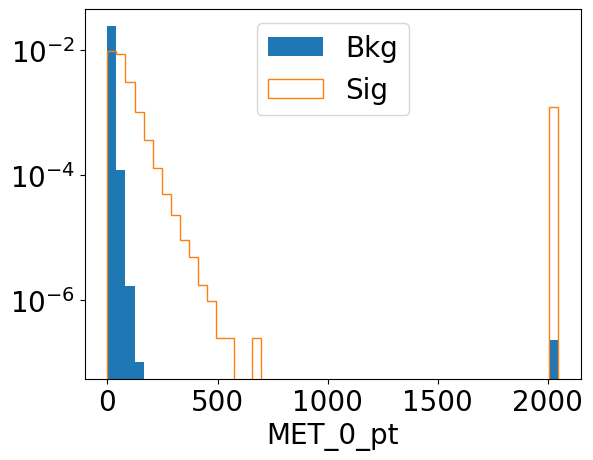

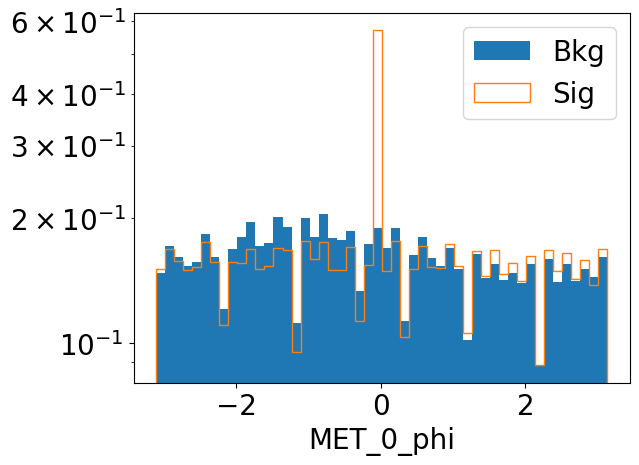

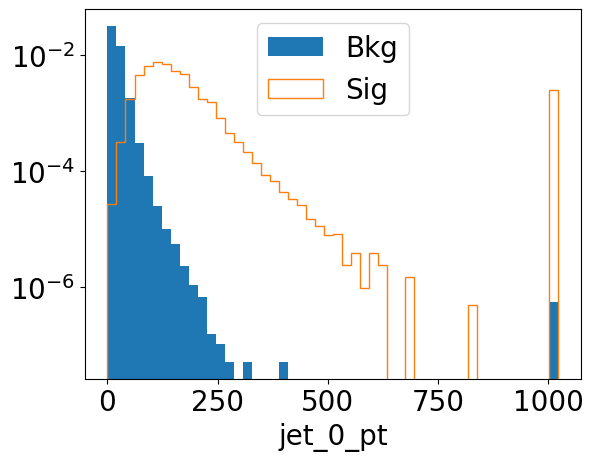

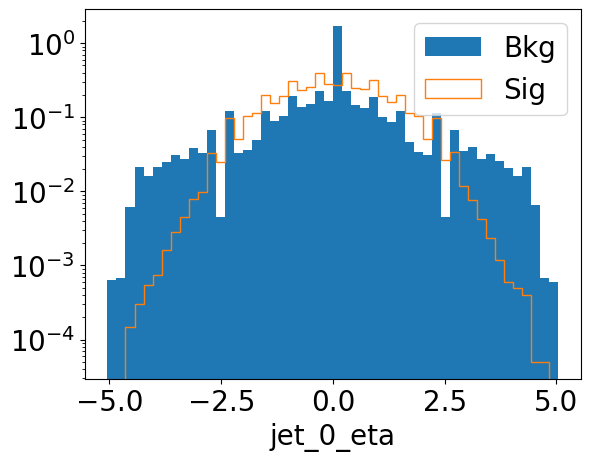

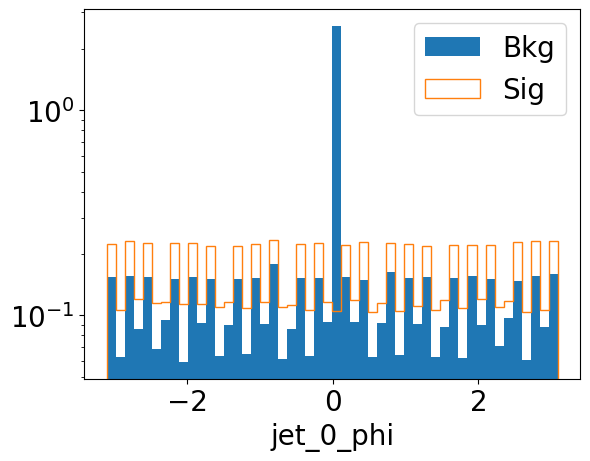

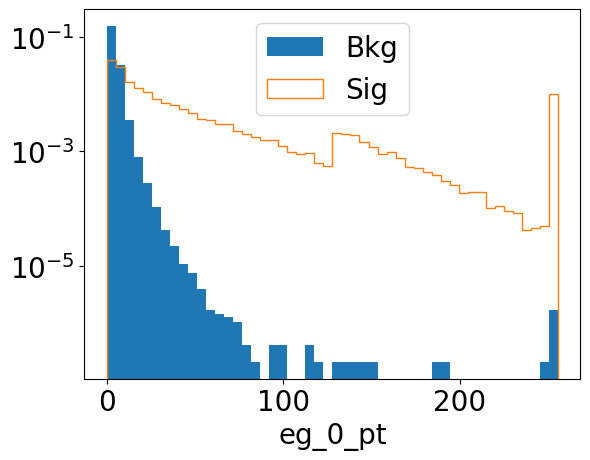

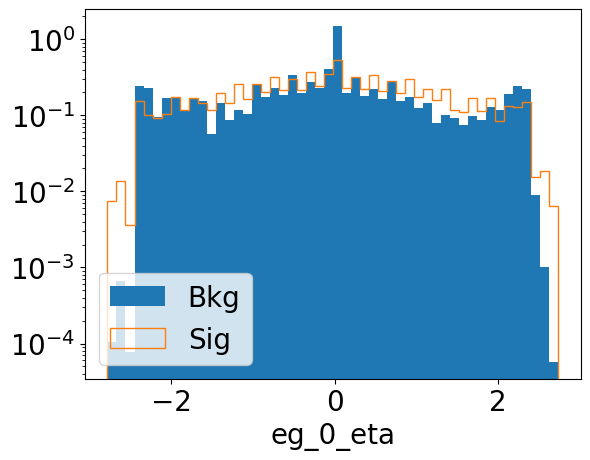

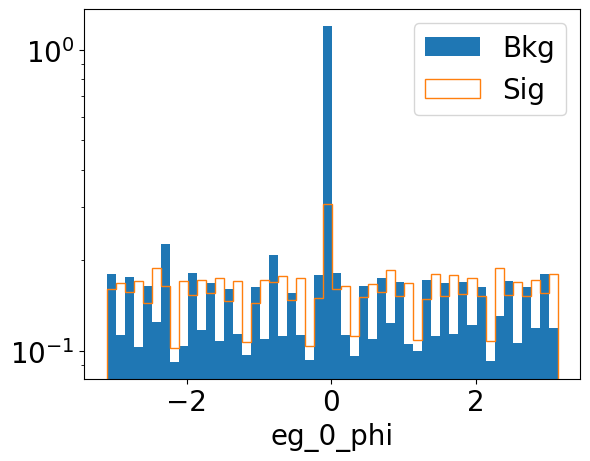

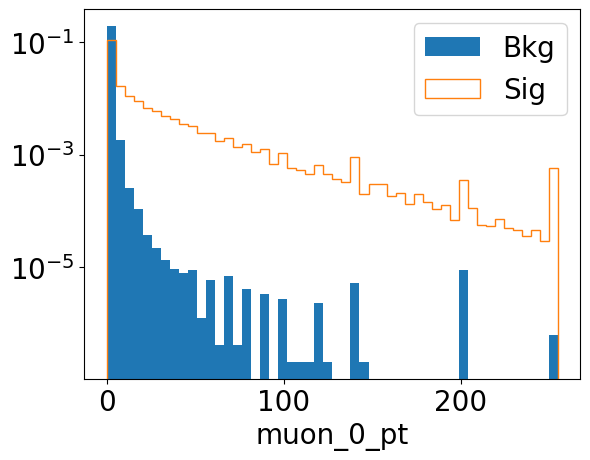

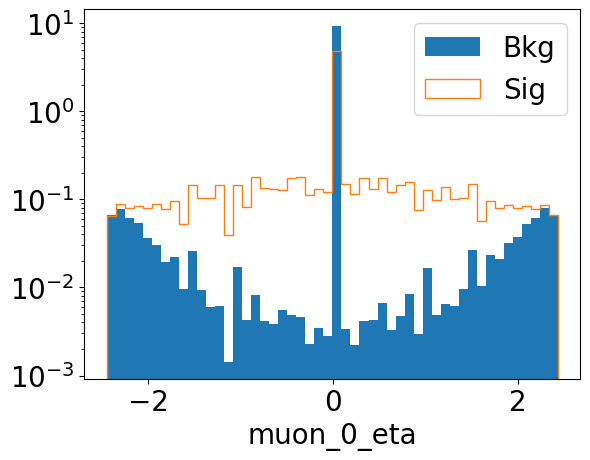

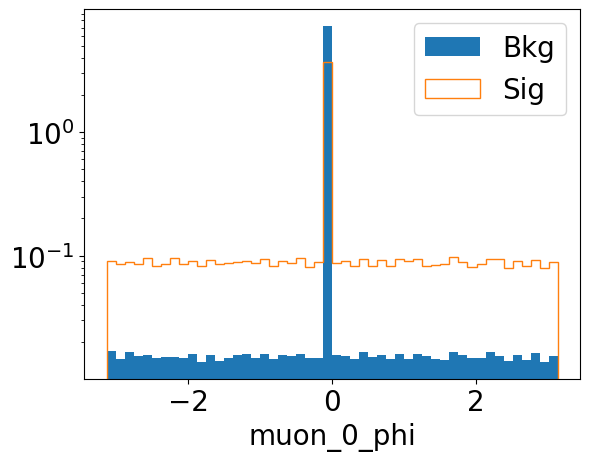

In [16]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()
#     break

You can see now that for the non-sum objects we have peaks at 0 as this was the `pad_val` padding value for filling empty variables.

### Final preprocessing: concatenating sig/bkg, scaling and train/test splitting

Finally, we have to concatenate the signal and background arrays:

In [17]:
# creating labels
y_bkg = np.zeros(len(x_bkg))
y_sig = np.ones(len(x_sig))

# combining signal & bkg
x = np.concatenate((x_bkg, x_sig))
y = np.concatenate((y_bkg, y_sig))

Then, we need to scale / normalise the inputs to be able to use them together in the NN training

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(x)
x_scaled = scaler.transform(x)

We will save the scaler and data for the next parts:

In [19]:
# make directory
outdir = "part1_outputs/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [20]:
with open(outdir+"scaler.pkl", 'wb') as file_pi: 
    pickle.dump(scaler, file_pi)

And split dataset to train/test samples

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.5)

We will save the train/test data now using awkward's `to_parquet` function:

In [22]:
ak.to_parquet(X_train, outdir+"X_train_scaled.parquet")
ak.to_parquet(y_train, outdir+"y_train_scaled.parquet")

  created_by: parquet-cpp-arrow version 14.0.1
  num_columns: 1
  num_rows: 523217
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [23]:
ak.to_parquet(X_test, outdir+"X_test_scaled.parquet")
ak.to_parquet(y_test, outdir+"y_test_scaled.parquet")

  created_by: parquet-cpp-arrow version 14.0.1
  num_columns: 1
  num_rows: 523218
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [24]:
! ls -lthr part1_outputs

total 63M
-rw-r--r--. 1 alobanov zh 1.8K Dec  7 22:50 scaler.pkl
-rw-r--r--. 1 alobanov zh  32M Dec  7 22:50 X_train_scaled.parquet
-rw-r--r--. 1 alobanov zh  99K Dec  7 22:50 y_train_scaled.parquet
-rw-r--r--. 1 alobanov zh  32M Dec  7 22:50 X_test_scaled.parquet
-rw-r--r--. 1 alobanov zh  99K Dec  7 22:50 y_test_scaled.parquet


These files can be read with `ak.read_parquet("filename.parquet")` afterwards.

# 2. Train NN classifier

Now we can move one to the NN training. 
We will use a simple fully-connected 3 layer network with 64/32/32 nodes following the HLS4ML tutorial: https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part1_getting_started.ipynb

In [25]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(1, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))

2023-12-07 22:50:58.144396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (34)


In [26]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                3648      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 1)                 3

Next, we will train the model with 10 epochs and record the history

In [28]:
%%time
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.25,
    shuffle=True,
#     callbacks=callbacks.callbacks,
)

Epoch 1/10
384/384 [==============================] - 3s 3ms/step - loss: 0.5179 - accuracy: 0.8748 - val_loss: 0.2300 - val_accuracy: 0.9637
Epoch 2/10
384/384 [==============================] - 1s 2ms/step - loss: 0.1562 - accuracy: 0.9782 - val_loss: 0.1248 - val_accuracy: 0.9848
Epoch 3/10
384/384 [==============================] - 1s 2ms/step - loss: 0.1144 - accuracy: 0.9876 - val_loss: 0.1081 - val_accuracy: 0.9887
Epoch 4/10
384/384 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.9902 - val_loss: 0.1003 - val_accuracy: 0.9905
Epoch 5/10
384/384 [==============================] - 1s 3ms/step - loss: 0.0970 - accuracy: 0.9910 - val_loss: 0.0950 - val_accuracy: 0.9913
Epoch 6/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9917 - val_loss: 0.0905 - val_accuracy: 0.9918
Epoch 7/10
384/384 [==============================] - 1s 3ms/step - loss: 0.0877 - accuracy: 0.9921 - val_loss: 0.0863 - val_accuracy: 0.9922
Epoch 

We will save the model and history too:

In [29]:
model.save(outdir + "/model.h5")

with open(outdir + "/history.pkl", 'wb') as file_pi: pickle.dump(history, file_pi)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-12-07 22:51:10           64
variables.h5              

Below is a convenience function to plot the training history

In [30]:
def plotTrainingHistory(history, metrics = ["loss", "accuracy"], f = None, axs = None):
    
    # creating the plot
    if not f and not axs:
        f, axs = plt.subplots(len(metrics), 1, figsize = (12, 4*len(metrics)), sharex = True)
    if len(metrics) == 1:
        axs = [axs]
    plt.subplots_adjust(wspace=0, hspace=0)

    # labeling
#     hep.cms.label("private work", data=False, ax=axs[0])

    for i in range(len(metrics)):
        
        metric = metrics[i]
        ax = axs[i]
        ax.set_ylabel(metric)
        
        if isinstance(history, list): # handle kfold
            for foldi in range(len(history)):
                ax.plot(history[foldi].history[metric], color = "C{}".format(foldi))
                ax.plot(history[foldi].history['val_' + metric], color = "C{}".format(foldi), linestyle = "--")
                
            la2, = ax.plot([0,0], [0,0], color="Grey")
            lb2, = ax.plot([0,0], [0,0], color="Grey", linestyle = "--")
            ax.legend([la2, lb2], ["training", "validation"])
        else: 
            xs = np.arange(len(history.history['val_' + metric]))
            ax.plot(xs,history.history[metric], label = 'training')
            ax.plot(xs+.5, history.history['val_' + metric], label= 'validation')
            ax.legend()

    axs[-1].set_xlabel("Epoch")
    
    return f, axs


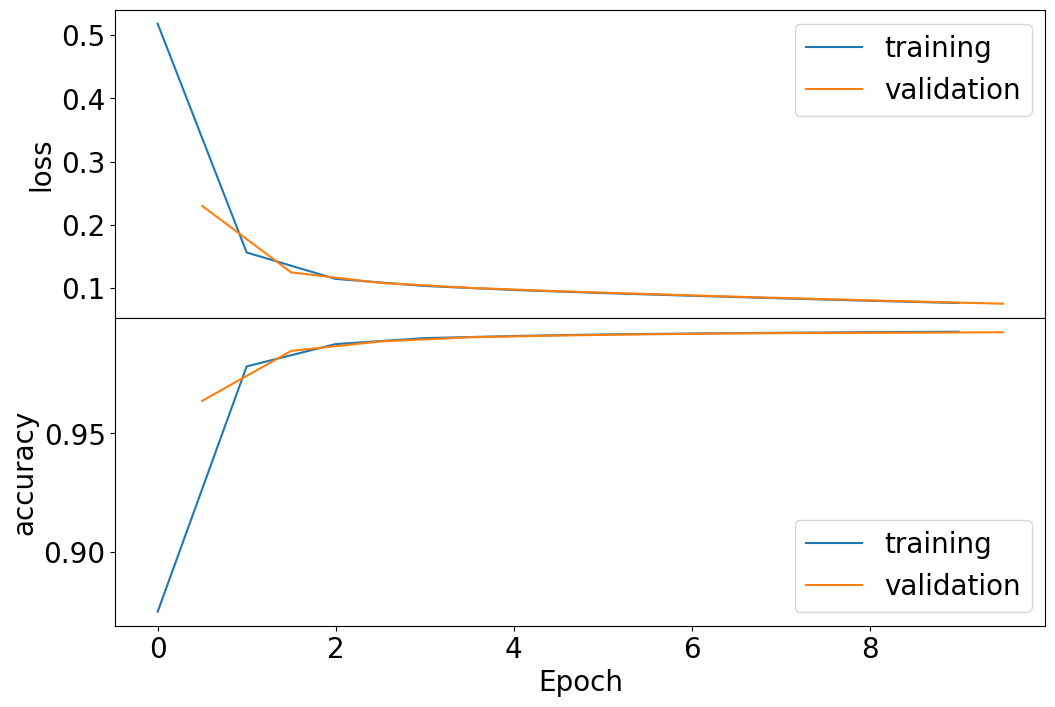

In [31]:
fig = plotTrainingHistory(history)

We can see that the model converges nicely and does not seem to overtrain.

### Make ROC

Next, we will make a ROC curve for the test dataset:

In [32]:
%%time
y_test_pred = model.predict(X_test)

16351/16351 [==============================] - 12s 720us/step
CPU times: user 16.6 s, sys: 1.22 s, total: 17.9 s
Wall time: 17.1 s


In [33]:
# Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")

  created_by: parquet-cpp-arrow version 14.0.1
  num_columns: 1
  num_rows: 523218
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)

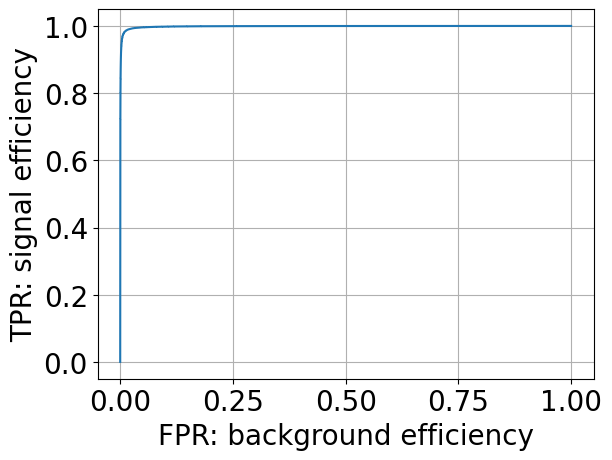

In [35]:
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.grid()

The AUC seems incredibly high! 

Though remember that at the L1 trigger level we look for reduction factors 1e4 (40 MHz -> 1 kHz), i.e. the FPR of interest lies much lower.

Much more practical is the rate in [k]Hz. In order to compute it we need to multiply the FPR with the LHC revolution frequency ~11kHz and the number of colliding bunches. The later can be looked up in the [Fill Report on OMS](https://cmsoms.cern.ch/cms/fills/report?cms_fill=9043) and is normally about 2500.

In [36]:
## for L1 rate estimates from ZeroBias/SingleNuMC
def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz

Let's now make the ROC plot and focus on a rate range 0-100 kHz:

(0.0, 100.0)

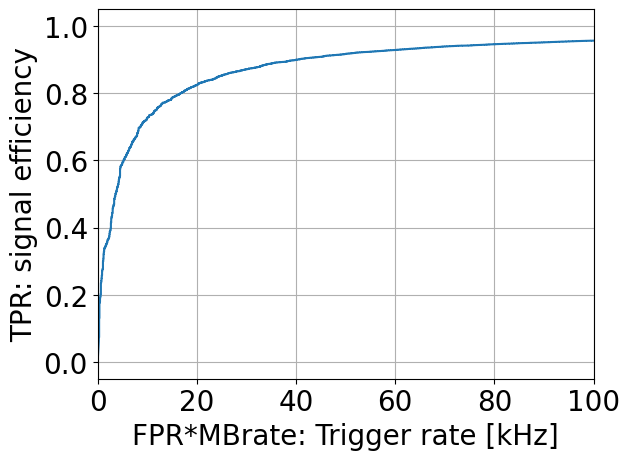

In [37]:
plt.plot(fpr * totalMinBiasRate(), tpr)
plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,100)

Voila! With 100 kHz our NN trigger has almost 100% signal efficiency :)
But even at rather low rates the signal acceptance is quite significant.

### In order to get a better judgement of the physics performance/relevance of this trigger, one should also take into consideration the current, "traditional" L1 menu seeds and compare to its efficiencies. This is done below in Section 3, but you can skip that for now if time does not permit, yet this is a crucial check to do if you want to propose a (any) new L1 trigger seed.

## 2. bis: Hardware input values

The uGT/FPGA firmware does not actually use the float variables as we did above. Instead, more hardware efficient integer values are used, called "hardware" (HW) variables. This is important when moving towards implementing the ML model in the actual FW -> ideally the training has to be done already with the HW features. 

Below we will load the HW representations of the features used above and compare them.

In [38]:
%%time
data_sig_hw = f_sig["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(hwPt|hwEta|hwPhi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

CPU times: user 776 ms, sys: 17.8 ms, total: 793 ms
Wall time: 901 ms


In [39]:
%%time
data_bkg_hw = f_bkg["Events"].arrays(
    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(hwPt|hwEta|hwPhi|etSumType)/", 
#     entry_stop = 1e1, 
    how = "zip"
)

CPU times: user 2.84 s, sys: 261 ms, total: 3.1 s
Wall time: 3.18 s


Note that we will define a dedicated HW object dictionary for the conversion to the tabular format:

In [40]:
hw_objects = [
    {"name" : "MET", "key" : "L1EtSum", "fields" : ["hwPt", "hwPhi"], "n_obj" : 1,
     "cuts" : [{"cuttype" : "equals", "field" : "etSumType", "value" : 2}] },  # etSumType 2 = MET noHF
    {"name" : "jet", "key" : "L1Jet", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 8},
    {"name" : "eg", "key" : "L1EG", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 8},
    {"name" : "muon", "key" : "L1Mu", "fields" : ["hwPt", "hwEta", "hwPhi"], "n_obj" : 2},
]

In [41]:
x_sig_hw, hw_var_names = formatDataTopotrigger(data_sig_hw, hw_objects, verbosity = 0)

In [42]:
x_bkg_hw, hw_var_names = formatDataTopotrigger(data_bkg_hw, hw_objects, verbosity = 0)

In [43]:
x_bkg_hw.shape, x_bkg.shape

((947200, 56), (947200, 56))

In [44]:
# combining signal & bkg
x_hw = np.concatenate((x_bkg_hw, x_sig_hw))

Let us compare the float and int/HW values:

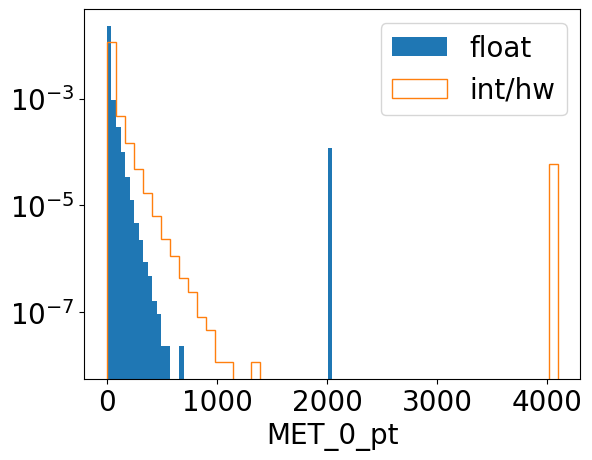

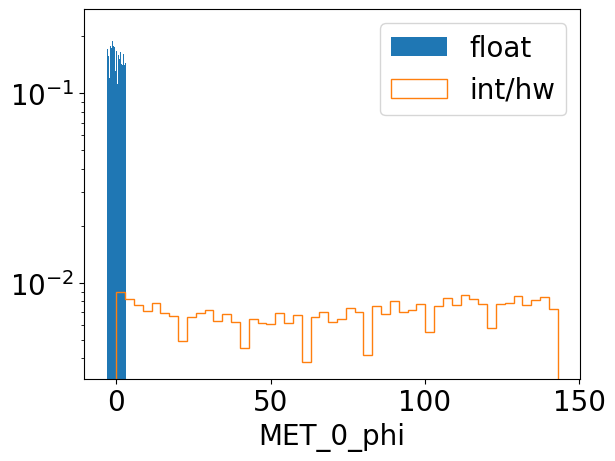

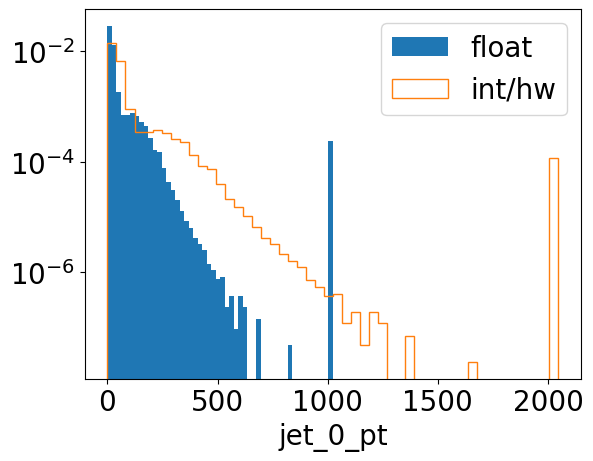

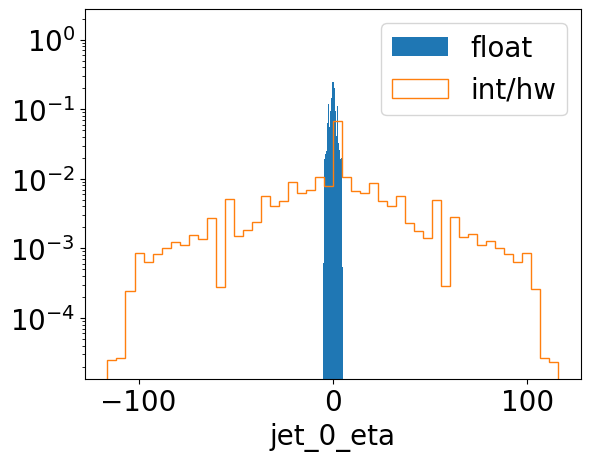

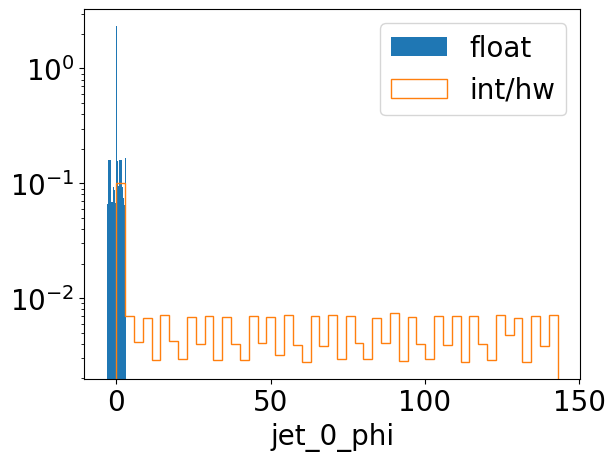

In [45]:
for i,name in enumerate(var_names[:10]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x[:,i], bins = 50, log = True, density = True, label = "float")
    _ = plt.hist(x_hw[:,i], bins = 50, histtype = "step", density = True, label = "int/hw")
    
    plt.xlabel(name)
    plt.legend()
#     break

Now we will will prepare a separate scaler for the HW values, and then we will save it for "Part 3" of this tutorial.

In [46]:
hwScaler = StandardScaler()
_ = hwScaler.fit(x_hw)
x_hw_scaled = hwScaler.transform(x_hw)

In [47]:
with open(outdir+"hwScaler.pkl", 'wb') as file_pi: 
    pickle.dump(hwScaler, file_pi)

And now we can compare the scaled values:

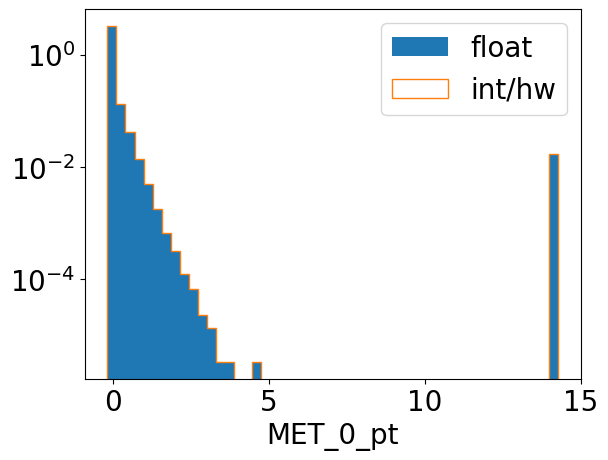

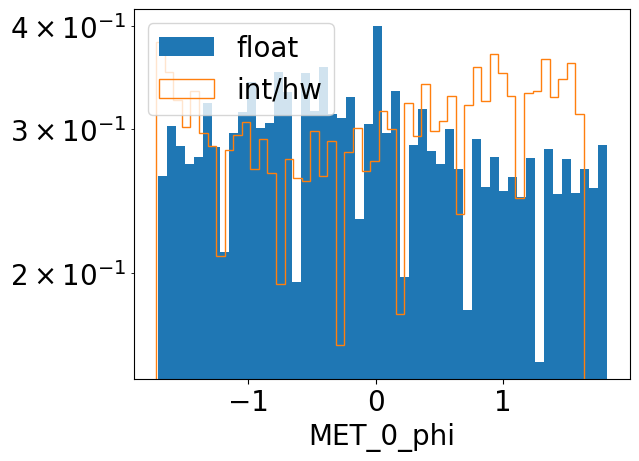

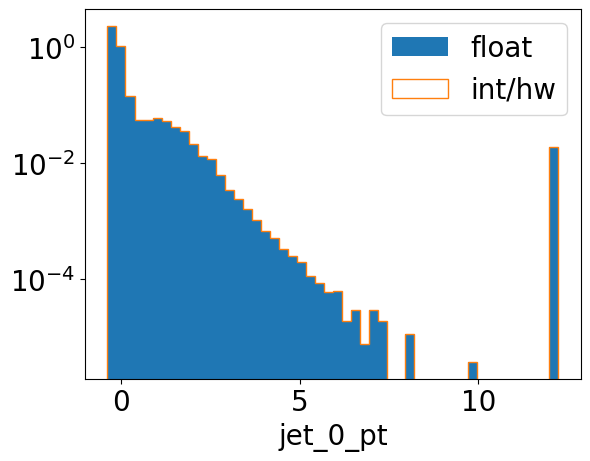

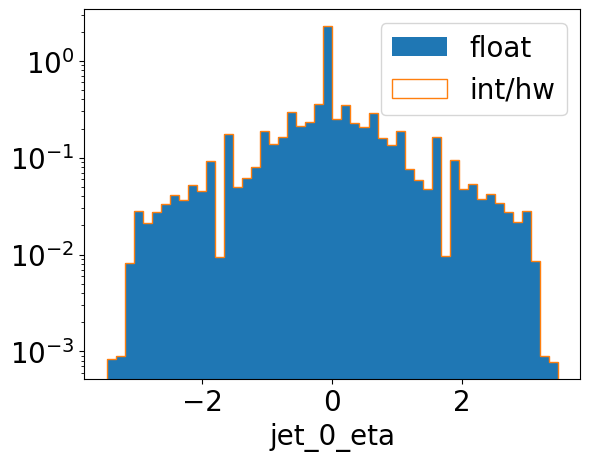

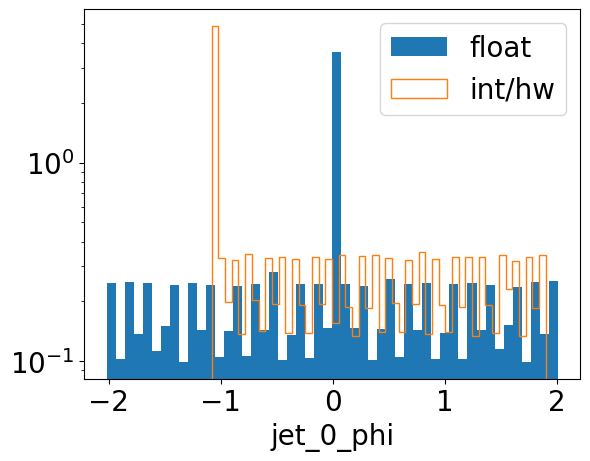

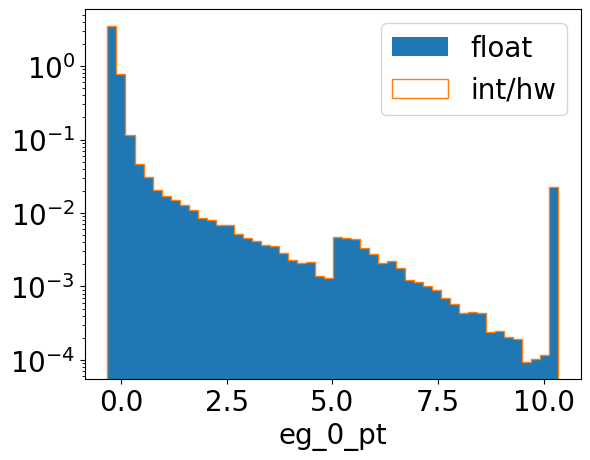

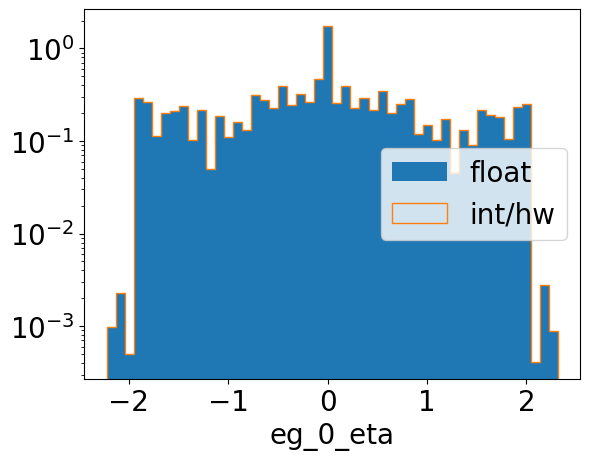

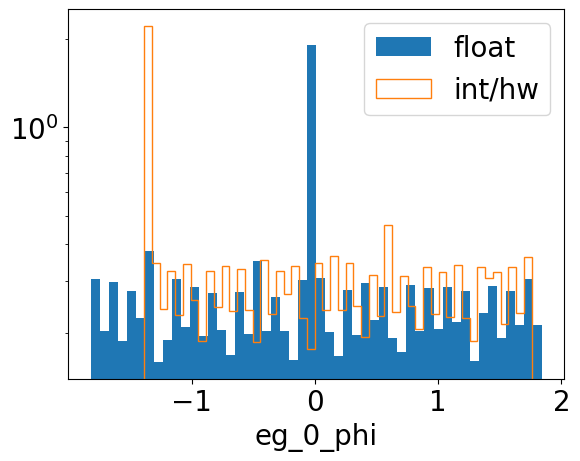

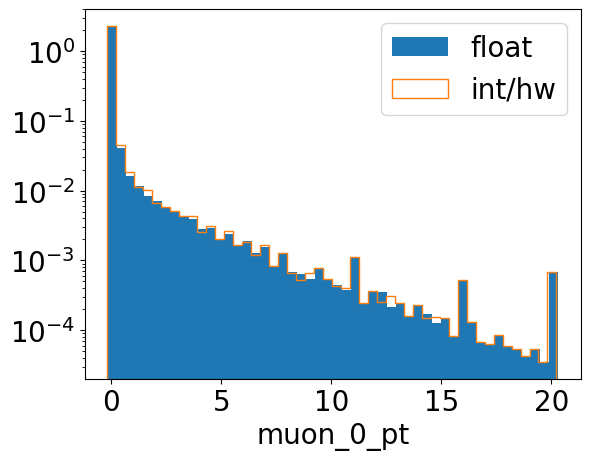

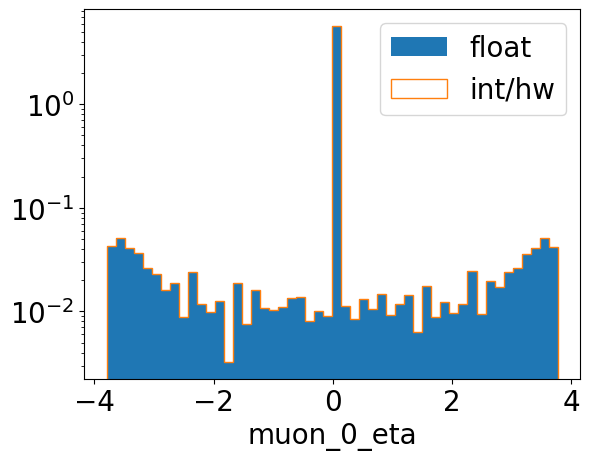

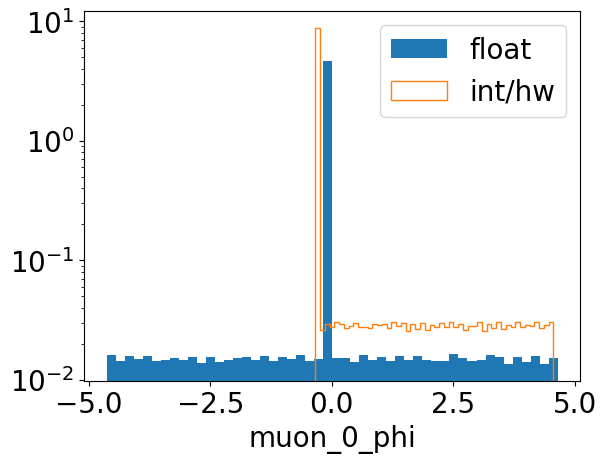

In [48]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_scaled[:,i], bins = 50, log = True, density = True, label = "float")
    _ = plt.hist(x_hw_scaled[:,i], bins = 50, histtype = "step", density = True, label = "int/hw")
    
    plt.xlabel(name)
    plt.legend()
#     break

Note that except for phi the scaled float and int/HW value distributions match rather nice.
The mismatches for pt/eta are mostly due to rounding effects, whereas for phi the "issue" is that the HW phi 0 value corresponds to -pi and hence the zero-padding results in an asymmetric distribution, unlike for the float variables.

Since the phi variables do not contribute much to the NN performance, we can for now ignore this inconsistency. In an actual application it is advisable to train the ML with HW variables directly though!

# 3. Study current L1 menu

The idea is to look at the acceptance (trigger efficiency) of the current L1 menu for our signal of interest

### Get list of unprescaled L1 seeds

We will load the prescale table from a recent menu e.g. https://github.com/cms-l1-dpg/L1MenuRun3/blob/master/official/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0.csv
(click on `RAW` view for the raw url to be used below)

In [49]:
# this is the Prescale (PS) table that was used for the MC generation:
# l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/development/L1Menu_Collisions2022_v1_3_0/PrescaleTable/L1Menu_Collisions2022_v1_3_0.csv"

## official PS table for 2023 
# l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0.csv"

## special PS table with backup seeds disabled for 1.9E34 column -> will use that one
l1_ps_url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/development/L1Menu_Collisions2023_v1_2_0/PrescaleTable/L1Menu_Collisions2023_v1_2_0-DedicatedPureRateStudy.csv"
df_l1_ps = pd.read_csv(l1_ps_url)
df_l1_ps.head()

,Index,Name,2p0E34,1p9E34
0,0,L1_SingleMuCosmics,0,0
1,1,L1_SingleMuCosmics_BMTF,0,0
2,2,L1_SingleMuCosmics_OMTF,0,0
3,3,L1_SingleMuCosmics_EMTF,0,0
4,4,L1_SingleMuOpen,0,0


Select unprescaled seeds (=`1`) for column "1p9E34" (this is a special PS table where backup seeds are disabled in this column)

In [50]:
# filter PS column
mask = df_l1_ps["2p0E34"] == 1
# mask = df_l1_ps["1p9E34"] == 1 # for special no-backup column
l1_unps_seeds = df_l1_ps[mask].Name.values
print(f"We selected {len(l1_unps_seeds)} out of {len(df_l1_ps)} L1 seeds.")

We selected 174 out of 411 L1 seeds.


### Load L1 seeds from the signal MC file

In [51]:
%%time
bits_sig = f_sig["Events"].arrays(filter_name = l1_unps_seeds, entry_stop = 1e7)

CPU times: user 2.4 s, sys: 17.5 ms, total: 2.41 s
Wall time: 3.03 s


In [52]:
len(bits_sig.fields)

156

One can see that while we expected 161 seeds, only 178 were loaded -> the missing were not in the menu used for the MC production!

In [55]:
# convert to a pandas dataframe for convenience
df_bits_sig = ak.to_dataframe(bits_sig) # might be to_pandas if using awkward < v2
df_bits_sig.head()

,L1_DoubleEG11_er1p2_dR_Max0p6,L1_DoubleEG8er2p5_HTT300er,L1_DoubleEG8er2p5_HTT320er,L1_DoubleEG8er2p5_HTT340er,L1_DoubleEG_25_12_er2p5,L1_DoubleEG_25_14_er2p5,L1_DoubleEG_27_14_er2p5,L1_DoubleEG_LooseIso18_LooseIso12_er1p5,L1_DoubleEG_LooseIso20_LooseIso12_er1p5,L1_DoubleEG_LooseIso22_12_er2p5,...,L1_TripleJet_105_85_75_DoubleJet_85_75_er2p5,L1_TripleJet_95_75_65_DoubleJet_75_65_er2p5,L1_TripleMu3_SQ,L1_TripleMu_5SQ_3SQ_0OQ_DoubleMu_5_3_SQ_OS_Mass_Max9,L1_TripleMu_5SQ_3SQ_0_DoubleMu_5_3_SQ_OS_Mass_Max9,L1_TripleMu_5_3_3,L1_TripleMu_5_3_3_SQ,L1_TripleMu_5_3p5_2p5_DoubleMu_5_2p5_OS_Mass_5to17,L1_TripleMu_5_4_2p5_DoubleMu_5_2p5_OS_Mass_5to17,L1_TripleMu_5_5_3
entry,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,False,True
3,False,True,True,True,True,True,True,False,False,True,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now we will compute the total number of counts and in addition the number of pure counts i.e. where only one seed has fired

In [56]:
%%time
counts = {}

for seed in df_bits_sig.columns:
    counts[seed] = {
        "total": df_bits_sig[seed].sum(), 
        "pure" :  (df_bits_sig[seed] & ~df_bits_sig.drop(seed, axis=1).any(axis=1)).sum(),
}
    
df_counts = pd.DataFrame(counts).T

CPU times: user 5.25 s, sys: 5.12 ms, total: 5.26 s
Wall time: 5.28 s


In [57]:
df_counts.sort_values("total", ascending = False)[:10]

,total,pure
L1_HTT280er,53706,194
L1_DoubleIsoTau34er2p1,51962,70
L1_DoubleIsoTau35er2p1,50877,0
L1_DoubleIsoTau36er2p1,49531,0
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,49263,447
L1_DoubleIsoTau26er2p1_Jet70_RmOvlp_dR0p5,44707,0
L1_HTT320er,43088,0
L1_LooseIsoEG28er2p1_HTT100er,36106,0
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,35768,3
L1_LooseIsoEG30er2p1_HTT100er,35184,0


Note that when we sort the seeds by the total counts as above we do have some high-count seeds with very low pure rate: these are in the "shadow" of other seeds when looking at this signal MC sample (but not necessarily on Background MC/ZeroBias!)

We will exlcude the seeds with low pure rate and sort by total again:

In [58]:
df_counts_pure = df_counts[df_counts.pure > 0]
df_counts_pure.sort_values("total", ascending = False)[:5]

,total,pure
L1_HTT280er,53706,194
L1_DoubleIsoTau34er2p1,51962,70
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,49263,447
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,35768,3
L1_SingleEG36er2p5,35111,44


In [59]:
len(df_counts_pure) # to check number of remaining seeds

46

Now we can compute the signal efficiencies by dividing the counts by the number of events

In [60]:
df_eff_pure = df_counts_pure/len(bits_sig)

In [61]:
df_eff_pure.sort_values("total", ascending = False)[:5]

,total,pure
L1_HTT280er,0.541200,0.001955
L1_DoubleIsoTau34er2p1,0.523626,0.000705
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,0.496428,0.004504
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,0.360437,0.000030
L1_SingleEG36er2p5,0.353817,0.000443


In [62]:
# # uncomment below to make a plot of the efficiencies
# ax = df_eff_pure.sort_values("total", ascending = True).plot(kind = "barh", figsize = (10,12))
# # ax.set_xscale("log")
# ax.set_xlabel("Signal efficiency")
# ax.grid()

### Rates for the unprescaled seeds using the background sample

We will use the above background dataset and only load the pure seeds we selected above for speed/performance.

In [63]:
%%time
bits_bkg = f_bkg["Events"].arrays(filter_name = df_counts_pure.index.values, entry_stop = 1e7)

CPU times: user 998 ms, sys: 28.9 ms, total: 1.03 s
Wall time: 8.52 s


In [64]:
%%time
df_bits_bkg = ak.to_dataframe(bits_bkg) # might be to_pandas if using awkward < v2

CPU times: user 173 ms, sys: 19.5 ms, total: 192 ms
Wall time: 189 ms


In [65]:
%%time
counts_bkg = {}

df = df_bits_bkg

for seed in df.columns:
#     print(seed)
    counts_bkg[seed] = {
        "total": df[seed].sum(), 
        "pure" :  (df[seed] & ~df.drop(seed, axis=1).any(axis=1)).sum(),

}
    
df_counts_bkg = pd.DataFrame(counts_bkg).T

CPU times: user 3.95 s, sys: 80.8 ms, total: 4.03 s
Wall time: 4.12 s


In [66]:
df_counts_bkg.sort_values("total", ascending = False)[:10]

,total,pure
L1_DoubleIsoTau34er2p1,312,149
L1_SingleEG36er2p5,265,60
L1_SingleIsoEG30er2p5,220,35
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,219,97
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,205,36
L1_HTT280er,176,21
L1_SingleMu22,171,129
L1_LooseIsoEG22er2p1_IsoTau26er2p1_dR_Min0p3,116,19
L1_DoubleJet_110_35_DoubleJet35_Mass_Min620,105,31
L1_DoubleJet30er2p5_Mass_Min250_dEta_Max1p5,101,10


We convert the counts to the rate using the total minbias rate we defined above:

In [67]:
df_rate_bkg = df_counts_bkg * totalMinBiasRate() / len(bits_bkg)

In [68]:
df_rate_bkg.sort_values("total", ascending = False)[:10]

,total,pure
L1_DoubleIsoTau34er2p1,9.260524,4.422494
L1_SingleEG36er2p5,7.865509,1.780870
L1_SingleIsoEG30er2p5,6.529856,1.038841
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,6.500175,2.879073
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,6.084639,1.068522
L1_HTT280er,5.223885,0.623304
L1_SingleMu22,5.075479,3.828870
L1_LooseIsoEG22er2p1_IsoTau26er2p1_dR_Min0p3,3.443015,0.563942
L1_DoubleJet_110_35_DoubleJet35_Mass_Min620,3.116522,0.920116
L1_DoubleJet30er2p5_Mass_Min250_dEta_Max1p5,2.997798,0.296812


You might notice that the rates are much lower than usually quoted. This is not only due to data/MC differences, but also due to the fact that here in MC we consider a wide PU range.

Only for reference: rates from OMS: https://cmsoms.cern.ch/cms/triggers/l1_rates?cms_run=370293&update=false

We can merge the signal efficiency and (background) rate dataframes for convenience:

In [69]:
df_eff_rate = df_eff_pure.join(df_rate_bkg, lsuffix = " eff", rsuffix = " rate")
df_eff_rate.sort_values("total eff", ascending = False)[:5]

,total eff,pure eff,total rate,pure rate
L1_HTT280er,0.541200,0.001955,5.223885,0.623304
L1_DoubleIsoTau34er2p1,0.523626,0.000705,9.260524,4.422494
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5,0.496428,0.004504,6.500175,2.879073
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3,0.360437,0.000030,6.084639,1.068522
L1_SingleEG36er2p5,0.353817,0.000443,7.865509,1.780870


Now we can make a "ROC" curve from the signal efficiency and rates for the L1 seeds.
For this we will first selecte the 5 "best" triggers for plotting:

In [70]:
best_trigs = list(df_eff_pure.sort_values("total", ascending = False)[:5].index)
best_trigs

['L1_HTT280er',
 'L1_DoubleIsoTau34er2p1',
 'L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5',
 'L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3',
 'L1_SingleEG36er2p5']

L1_HTT280er 0.5412001813876153 5.223885135135135
L1_DoubleIsoTau34er2p1 0.5236257368871869 9.260523648648649
L1_DoubleIsoTau26er2p1_Jet55_RmOvlp_dR0p5 0.4964276716884164 6.500175253378378
L1_LooseIsoEG28er2p1_Jet34er2p5_dR_Min0p3 0.3604373456945634 6.084638935810811
L1_SingleEG36er2p5 0.35381669773769336 7.865508868243243


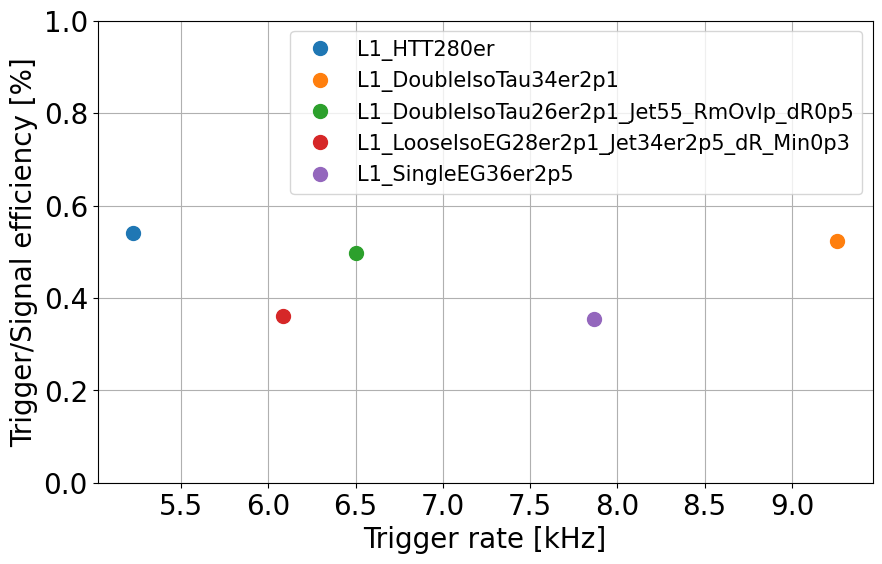

In [71]:
plt.figure(figsize = (10,6))

for trig in best_trigs:
    eff = df_eff_rate.loc[trig,"total eff"]
    rate = df_eff_rate.loc[trig,"total rate"]
    print(trig, eff, rate)
    
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
plt.legend(fontsize = 15)
plt.ylim(0,1)
# plt.xlim(0,)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

# 4. Compare NN vs L1 seeds

Finally, we can compare the NN and L1 menu triggers in one plot:

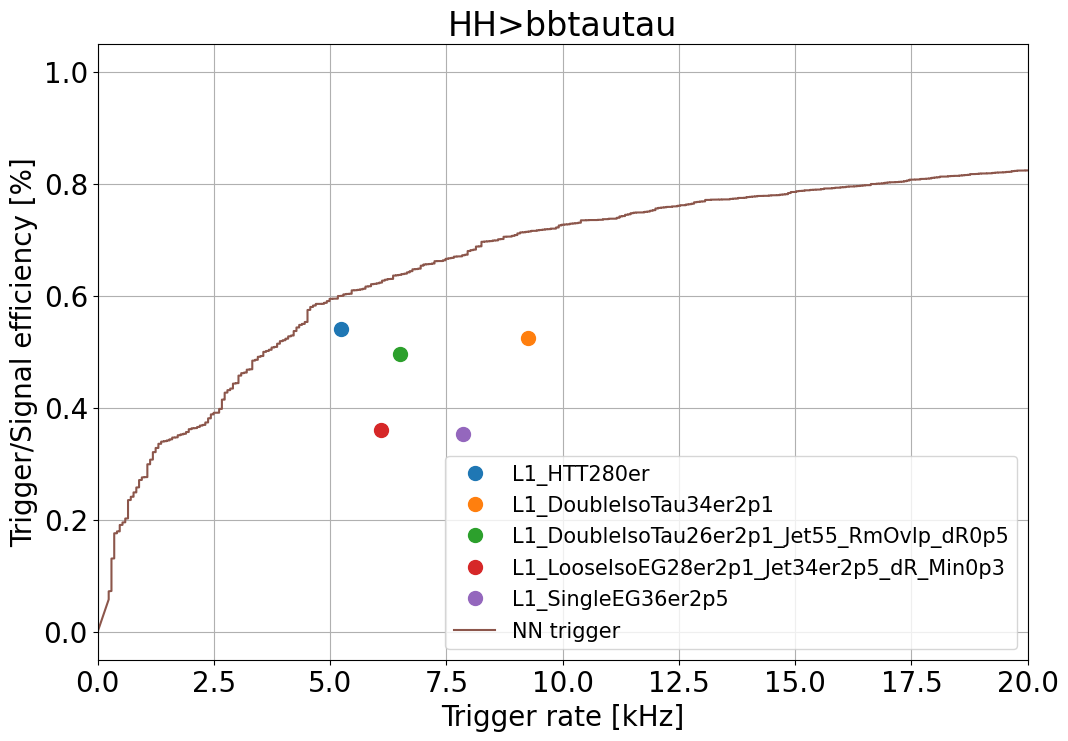

In [72]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_rate.loc[trig,"total eff"]
    rate = df_eff_rate.loc[trig,"total rate"]
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
    
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
    
plt.xlim(0,20)
plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

We can also add the OR of the full L1 menu and of the best triggers:

In [73]:
bits = np.concatenate((bits_bkg, bits_sig))

In [74]:
all_trig_or = False

for trig in bits.fields:
    all_trig_or = all_trig_or | bits[trig]

In [75]:
best_bits_or = False

for trig in best_trigs:
    best_bits_or = best_bits_or | bits[trig]

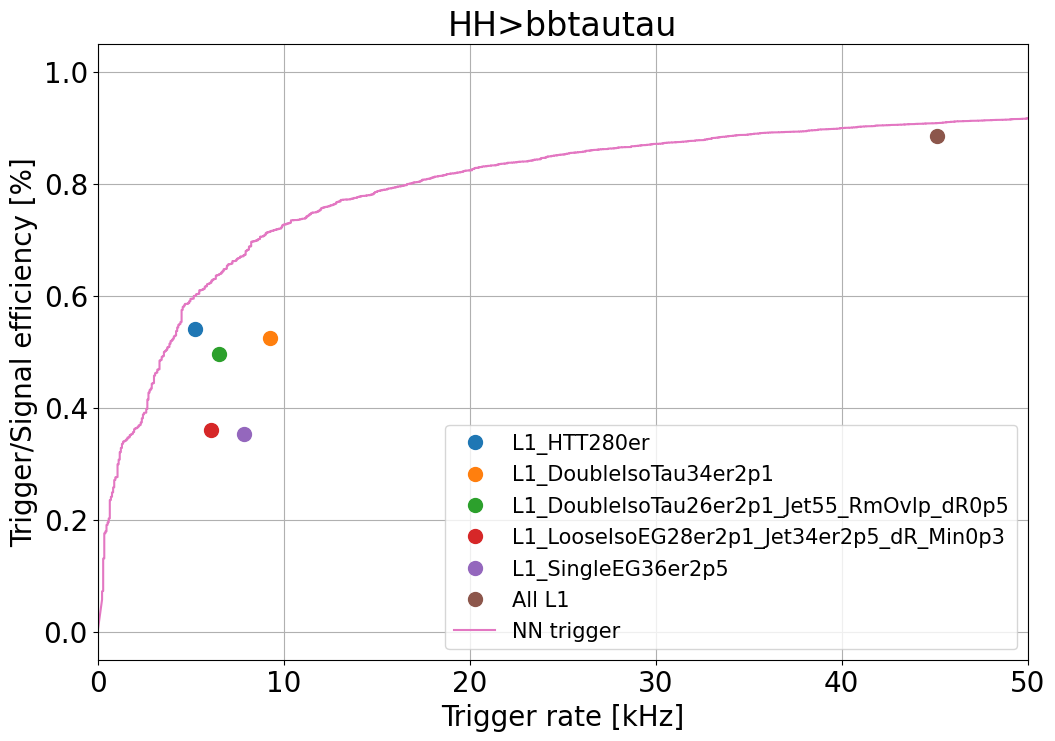

In [76]:
# Make a "ROC" curve from the signal efficiency and rates

plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]
#     print(trig, eff, rate)
    
    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)
    
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
    
plt.xlim(0,50)
plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

Note that the `All L1` menu rate is unrealistic since the MC PU profile is lower than what the considered menu was designed for!

**Bonus**: we can also make a ROC curve for the L1 HT variable to check if we could lower the HT threshold and compare to the NN ROC.

For this we first need to extract the L1 HT from the data:

In [77]:
# L1 l1ht
l1ht_sig = data_sig.L1EtSum[data_sig.L1EtSum["etSumType"] == 1].pt[:,0]
l1ht_bkg = data_bkg.L1EtSum[data_bkg.L1EtSum["etSumType"] == 1].pt[:,0]
l1ht_all = np.concatenate([l1ht_bkg,l1ht_sig])

Text(0.5, 0, 'L1 HT')

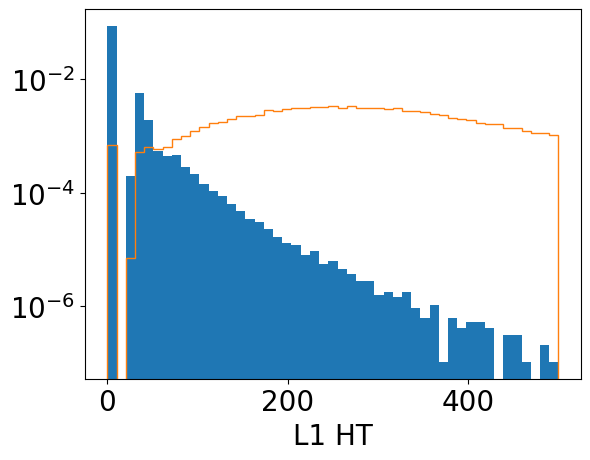

In [78]:
_ = plt.hist(l1ht_bkg, bins = np.linspace(0,500,50), log = True, density = 1,)
_ = plt.hist(l1ht_sig, bins = _[1], histtype = "step", density = 1,)
plt.xlabel("L1 HT")

Make the HT "ROC"

In [79]:
ht_fpr, ht_tpr, ht_thr = roc_curve(y, l1ht_all, drop_intermediate=False)
# plt.plot(ht_fpr, ht_tpr)

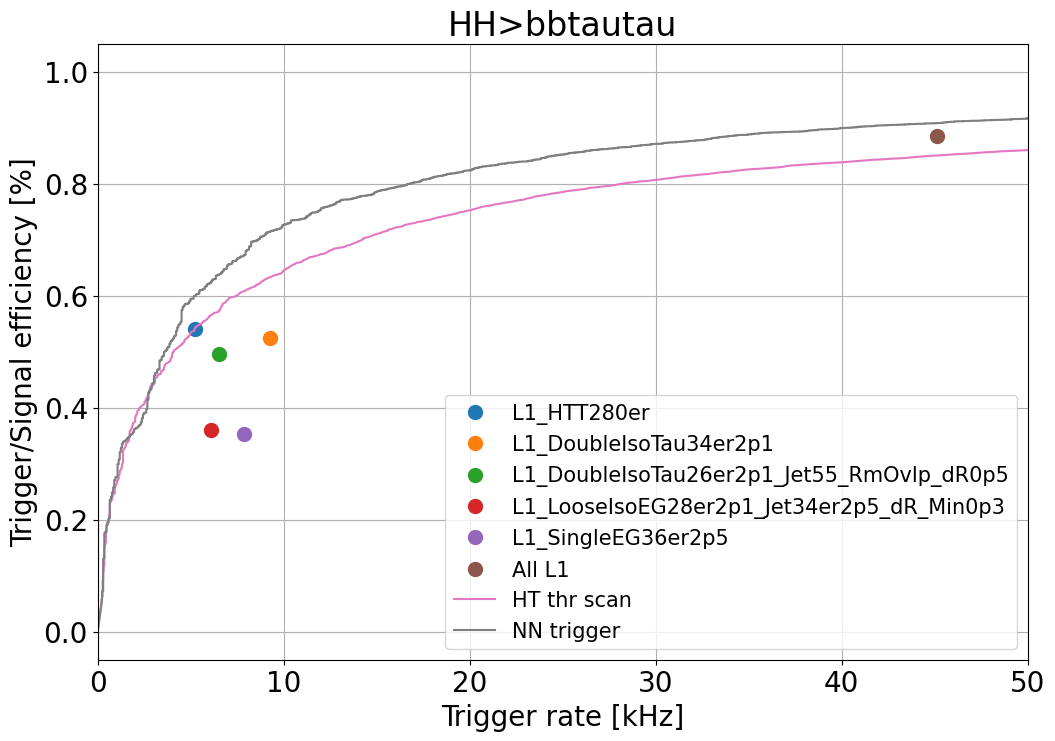

In [80]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]

    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)

## HT ROC
plt.plot(ht_fpr * totalMinBiasRate(), ht_tpr, label = "HT thr scan")
    
## NN
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")
  
plt.xlim(0,50)
# plt.xlim(1,1e3)
# plt.xscale("log")

plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

You can see that the `L1_HTT280er` seed point lies exactly on the HT scan curve which is a good cross-check.

Finally, the NN always outperforms the L1 Menu, even when all the seeds are combined.

# 5. Offline Efficiencies

In this part we will look into the trigger efficiencies with respect to some offline quantities such as MET and HT. 

This will help to see in which phase-space the NN trigger outperforms the traditional seeds.

We first need to load the offline Jets and MET for the signal:

In [81]:
%%time
f_sig = uproot.open(fname_sig)
events_sig = f_sig["Events"].arrays(
    filter_name = ["/Jet_(pt|eta|phi|jetId)/", "MET_pt"],
#     entry_stop = 1,
    how = "zip", 
)

CPU times: user 1.71 s, sys: 56.8 ms, total: 1.77 s
Wall time: 2.72 s


We will now compute the HT from jets with pt > 30, eta < 2.4 and jetId>=2

In [82]:
jets = events_sig.Jet
jets["mass"] = 0

jets_mask = (jets.pt > 30) & (abs(jets.eta) < 2.4) & (events_sig.Jet.jetId >= 2)
good_jets = ak.Array(jets[jets_mask], with_name = "Momentum4D")

ht_sig = ak.fill_none(ak.sum(good_jets.pt, axis = 1), 40)

We will plot the distribution of offline HT and then use this as the denominator.
The numerator will be the distribution after a certain trigger selection:

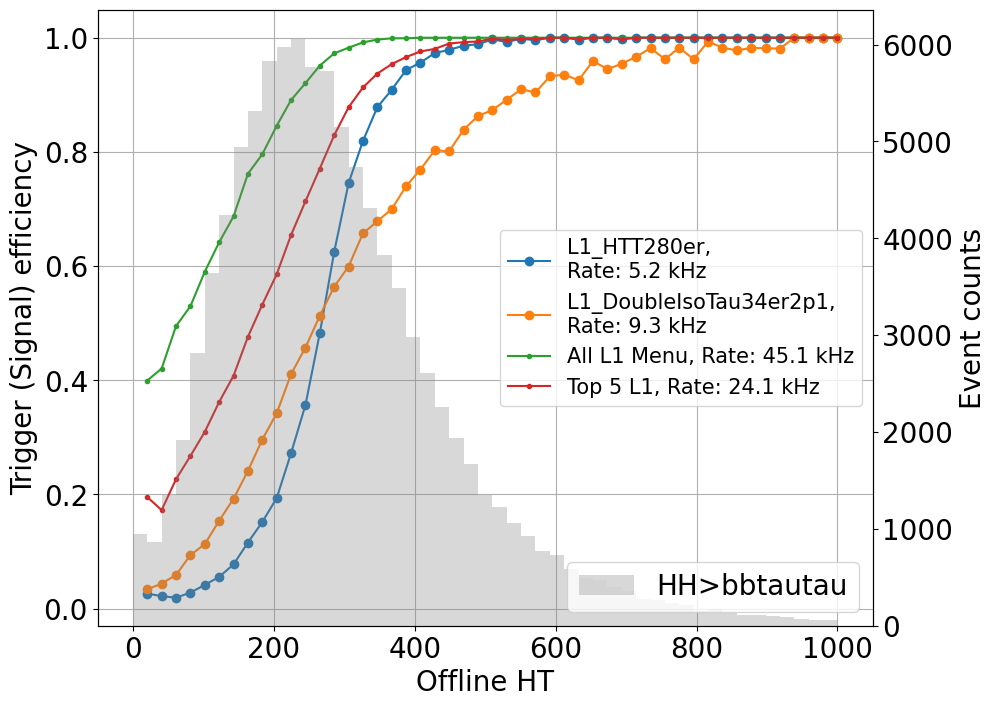

In [83]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in best_trigs[:2]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")
    
if True:
    num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
    rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")


# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

Now we need to make the NN prediction for the full sample, since we do not have the test/train split for the offline jets. We can do this since our model does not overtrain -> the train/test performance is similar

In [84]:
## this takes about 50 secs - time for a short break
y_pred = model.predict(x_scaled)[:,0]

32702/32702 [==============================] - 24s 722us/step


Now we add the NN for some reasonable threshold/rate values:

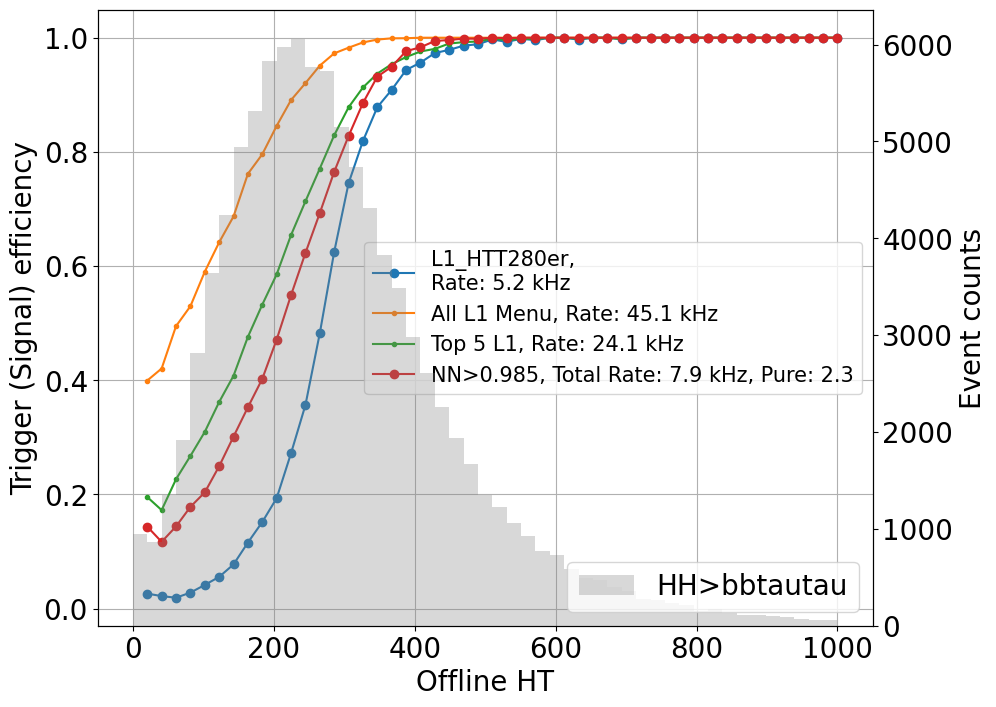

In [85]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in best_trigs[:1]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")
    
## All L1
if True:
    num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
    rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")

## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

ax1.grid()
ax1.legend(loc = 5, fontsize = 15)

We can look at the efficiencies also for the L1 HT:

/cvmfs/cms.cern.ch/el8_amd64_gcc11/external/py3-awkward/2.1.1-530dedc648fc6b920fd089a00a83e561/lib/python3.9/site-packages/awkward/_backends.py:58: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


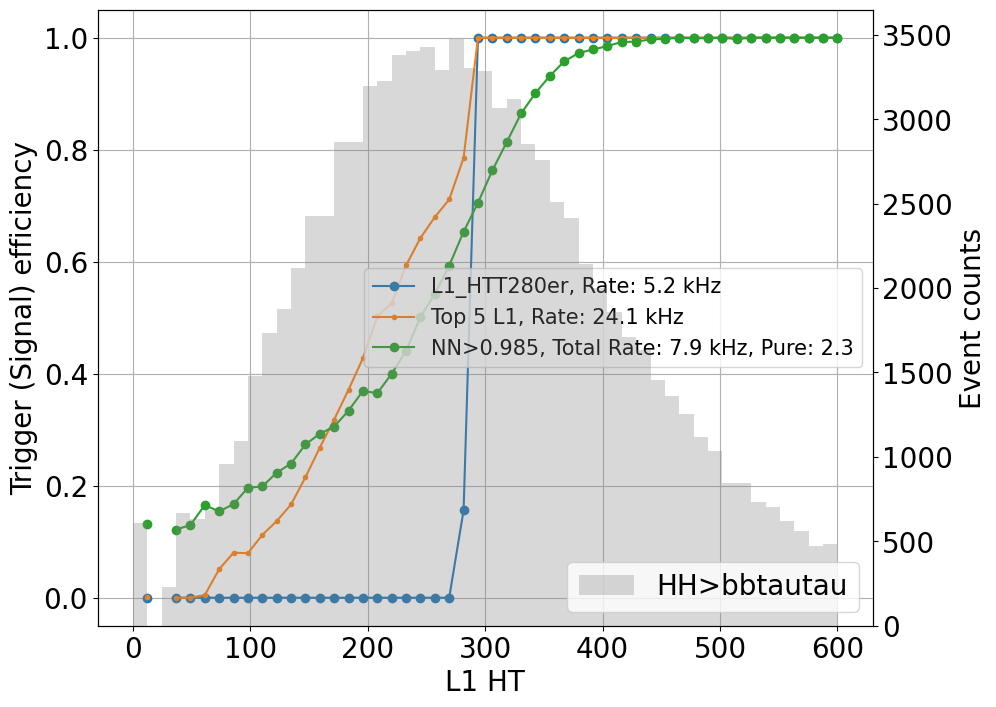

In [86]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("L1 HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = l1ht_sig
xbins = np.linspace(0,600,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

The L1 HT280 seed naturally is a step function (~rounding effects). 
But, interestingly, the NN plateaus after the 280 GeV threshold yet it shows a better efficiency for offline HT at this score threshold!

Finally we can check the efficiencies for some of the input features:

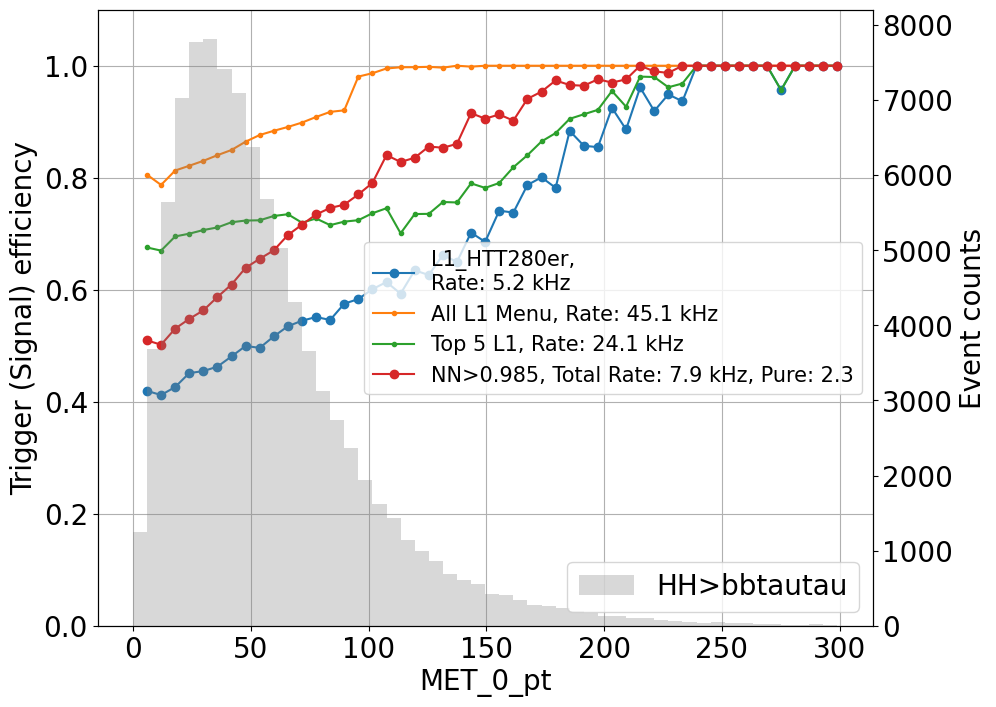

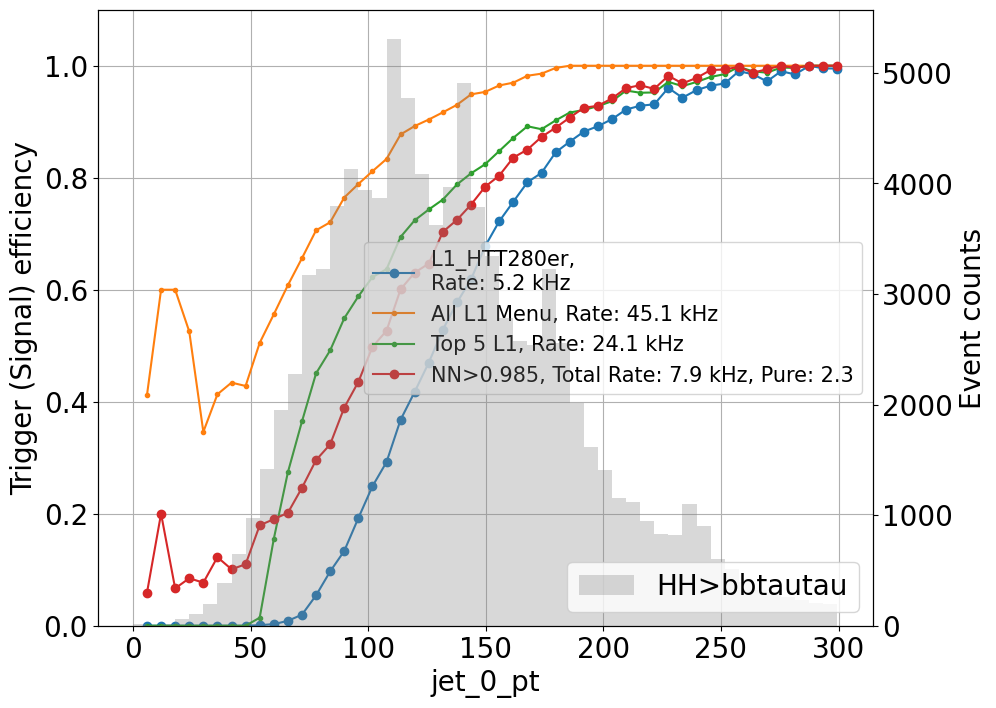

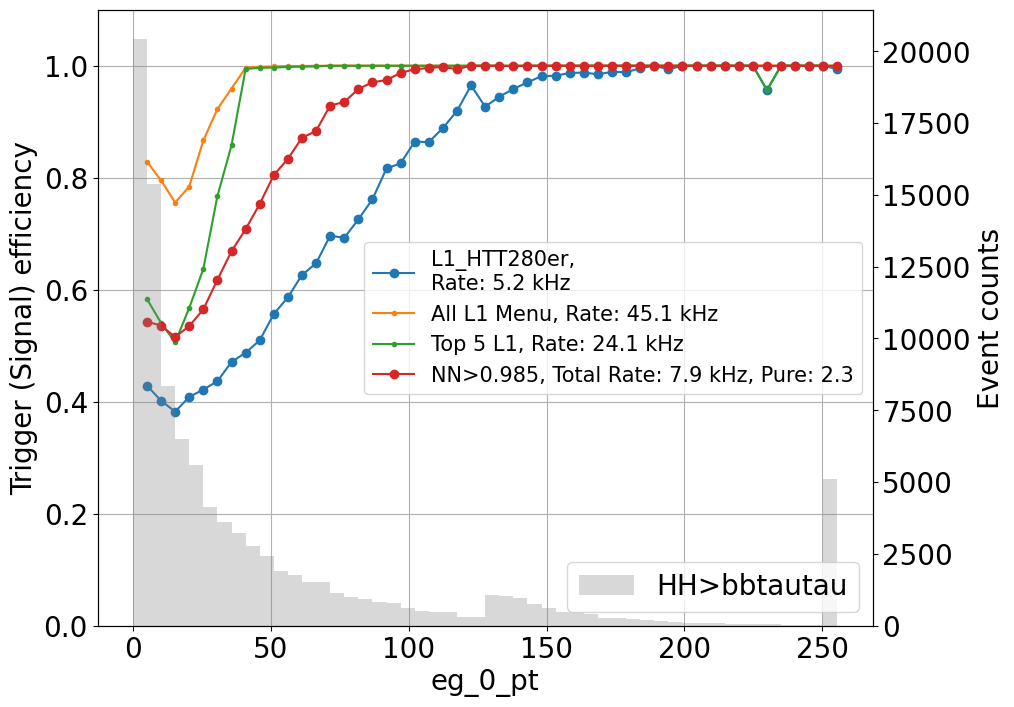

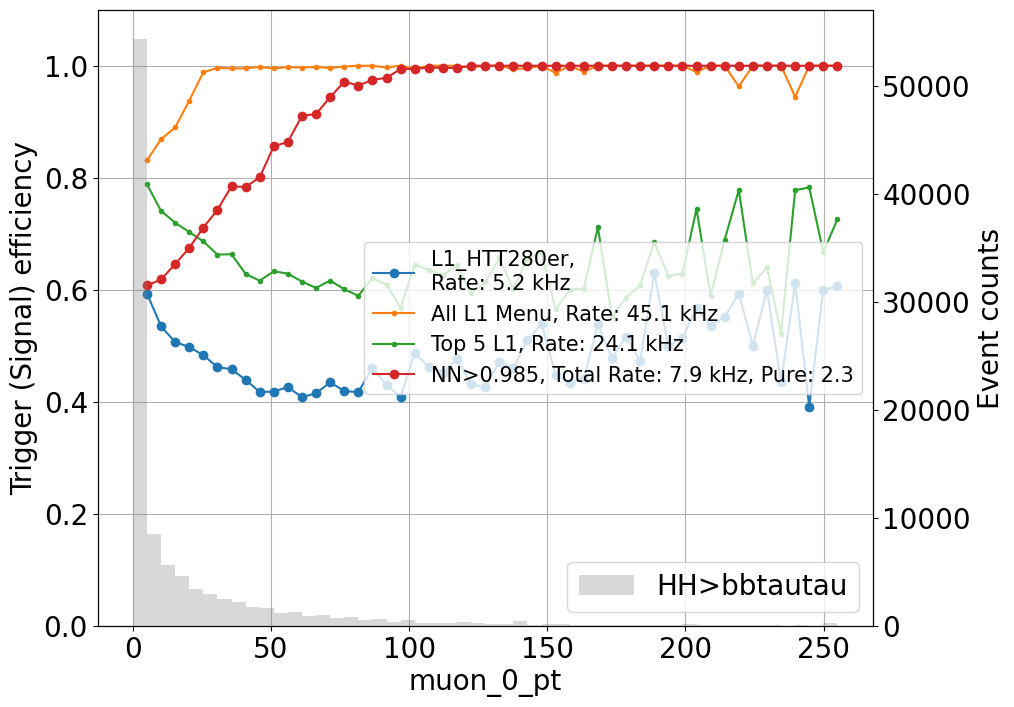

In [90]:
for i,name in enumerate(var_names):
    if "0_pt" not in name: continue
    
    f,ax1 = plt.subplots(figsize = (10,8))
    ax2 = ax1.twinx()
    ax1.set_xlabel(name)
    ax1.set_ylabel("Trigger (Signal) efficiency")

    xvar = x_sig[:,i]
    xbins = 50
    den = np.histogram(xvar[xvar<300], bins = xbins)
    ax2.hist(xvar, bins = den[1], label = "HH>bbtautau", color = "grey", alpha = 0.3)
    ax2.legend(loc = 4)
    ax2.set_ylabel("Event counts")

    #### L1 
    for trig in best_trigs[:1]:
        num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
        rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, \nRate: {rate:.1f} kHz")

    ## ALL L1
    if True:
        num = np.histogram(xvar[all_trig_or[y==1]], bins = den[1])
        rate = np.sum(all_trig_or[y==0]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"All L1 Menu, Rate: {rate:.1f} kHz")

    ## BEST 5
    if True:
        num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
        rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
        ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

    ## NN trigger
    for thr in [0.985]:
        trig_mask = (y_pred > thr) #& (x[:,2] > 50)
        num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

        rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
        pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()

        ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))


    ax1.set_ylim(0,1.1)
    ax1.grid()

    ax1.legend(loc = 5, fontsize = 15)

#     break

# Bonus: BDT

We will try out a BDT instead of an NN for the same classification task:

In [91]:
from xgboost import XGBClassifier

In [92]:
bdt = XGBClassifier(n_estimators=20, max_depth=3, learning_rate=1, 
                        objective='binary:logistic',
                       )

In [93]:
%%time
_ = bdt.fit(X_train, y_train)

CPU times: user 38.2 s, sys: 238 ms, total: 38.4 s
Wall time: 5.92 s


In [94]:
%%time
y_bdt = bdt.predict_proba(x_scaled)[:,1]

CPU times: user 1.01 s, sys: 53 ms, total: 1.06 s
Wall time: 214 ms


We will also check the ROCs for the test/train separately to check for overtraining:

In [95]:
%%time
y_test_bdt = bdt.predict_proba(X_test)[:,1]
y_train_bdt = bdt.predict_proba(X_train)[:,1]

CPU times: user 1.12 s, sys: 12.6 ms, total: 1.13 s
Wall time: 190 ms


(0.0, 20.0)

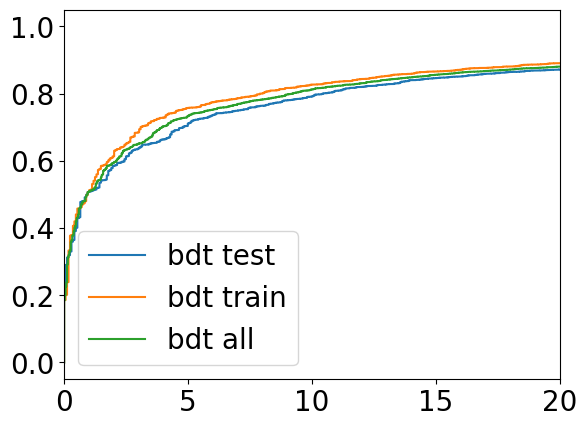

In [96]:
fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y_test, y_test_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt test")

fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y_train, y_train_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt train")

fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y, y_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "bdt all")

plt.legend()
plt.xlim(0,20)
# plt.xscale("log")

Extra: feature importance from BDT/bdt!

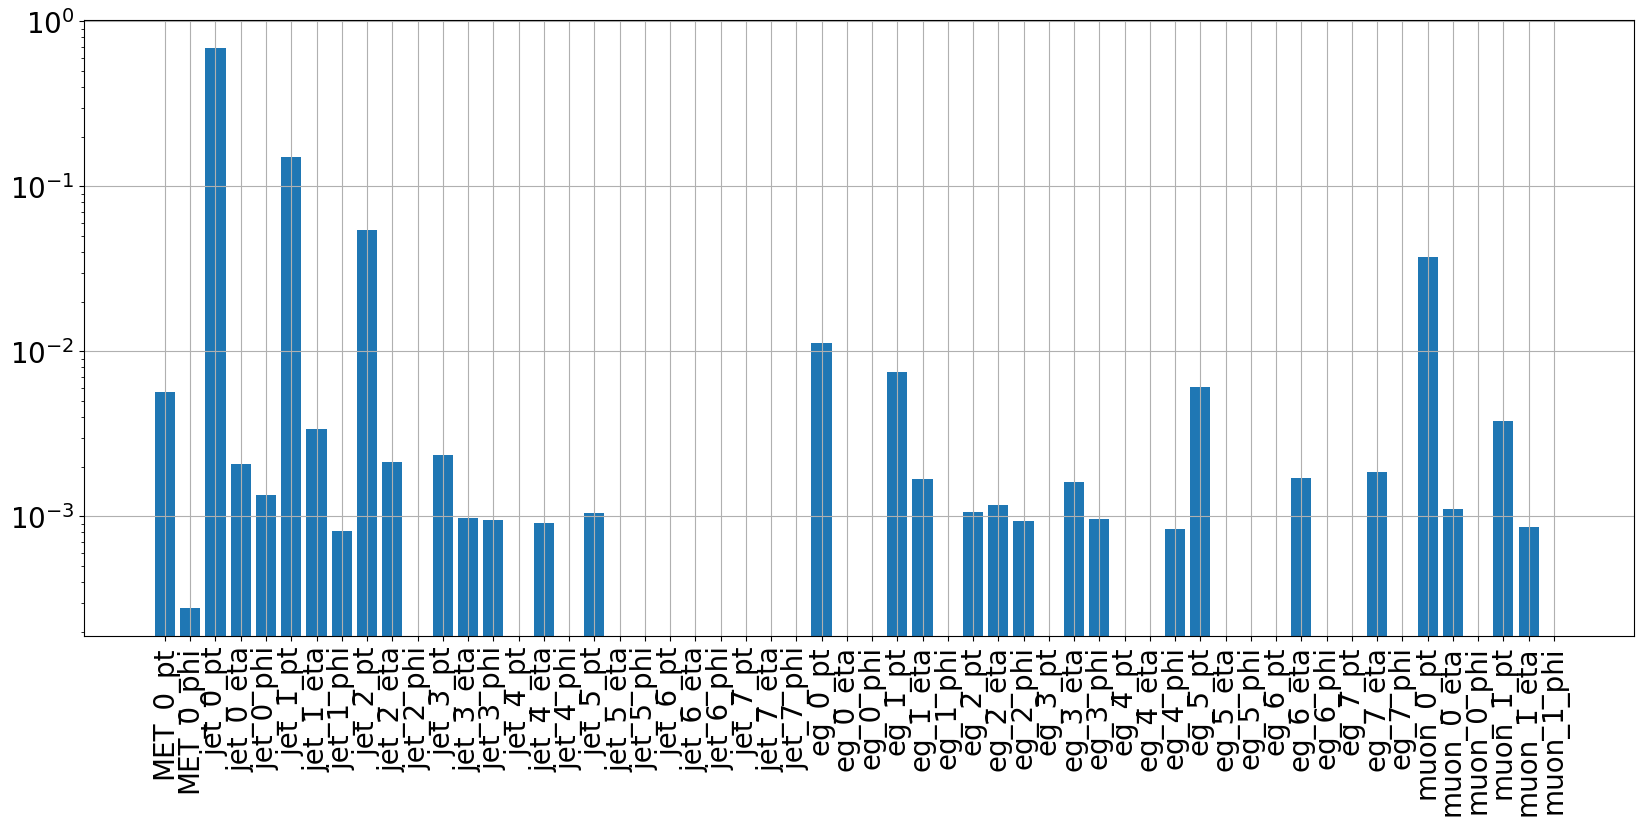

In [97]:
plt.figure(figsize = (20,8))
plt.bar(var_names, bdt.feature_importances_)
plt.yscale("log")
plt.xticks(rotation = 90)
plt.grid()

We can add the BDT to the ROC curves:

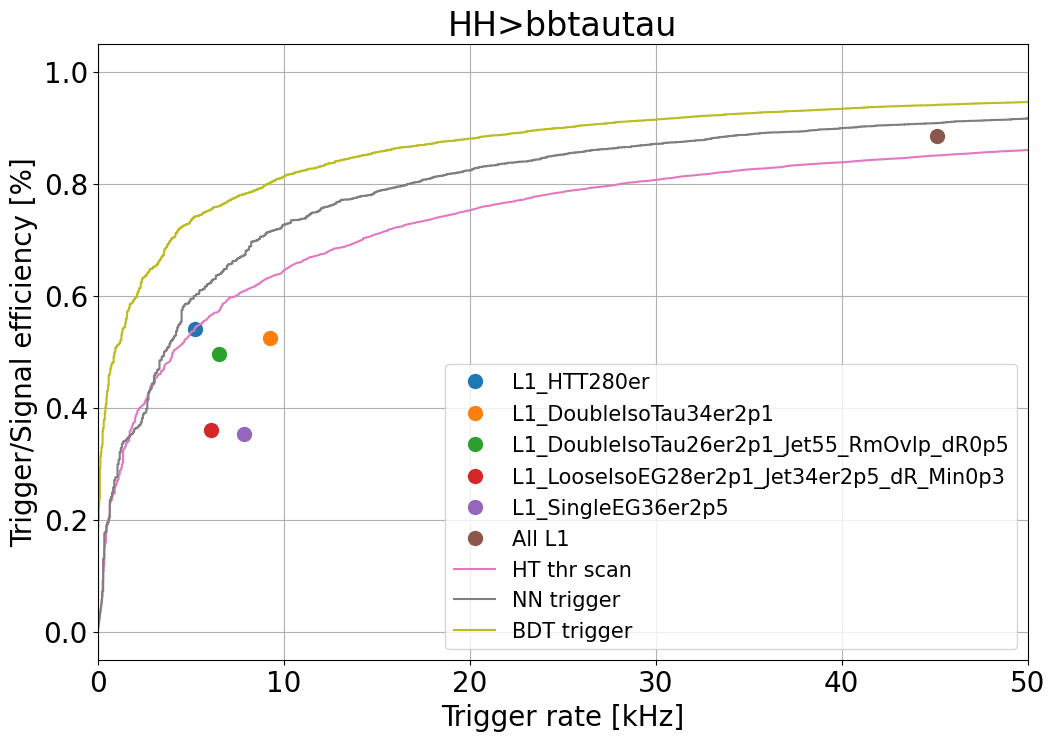

In [98]:
plt.figure(figsize = (12,8))
plt.title("HH>bbtautau")

for trig in best_trigs:
    eff = df_eff_pure.loc[trig,"total"]
    rate = df_rate_bkg.loc[trig,"total"]

    plt.plot(rate, eff, "o", label = trig, ms = 10)
    
## total L1 menu
eff = np.sum(all_trig_or[y==1]) / np.sum(y==1)
rate = np.sum(all_trig_or[y==0]) / np.sum(y==0) * totalMinBiasRate()
plt.plot(rate, eff, "o", label = "All L1", ms = 10)

## HT ROC
plt.plot(ht_fpr * totalMinBiasRate(), ht_tpr, label = "HT thr scan")
    
## NN
plt.plot(fpr * totalMinBiasRate(), tpr , label = "NN trigger")

## BDT
fpr_bdt, tpr_bdt, thr_bdt = roc_curve(y, y_bdt, drop_intermediate=False)
plt.plot(fpr_bdt * totalMinBiasRate(), tpr_bdt , label = "BDT trigger")
  
plt.xlim(0,50)
# plt.xlim(1,1e3)
# plt.xscale("log")

plt.legend(fontsize = 15)
plt.ylabel("Trigger/Signal efficiency [%]")
plt.xlabel("Trigger rate [kHz]")
plt.grid()

We can also check the efficiencies again:

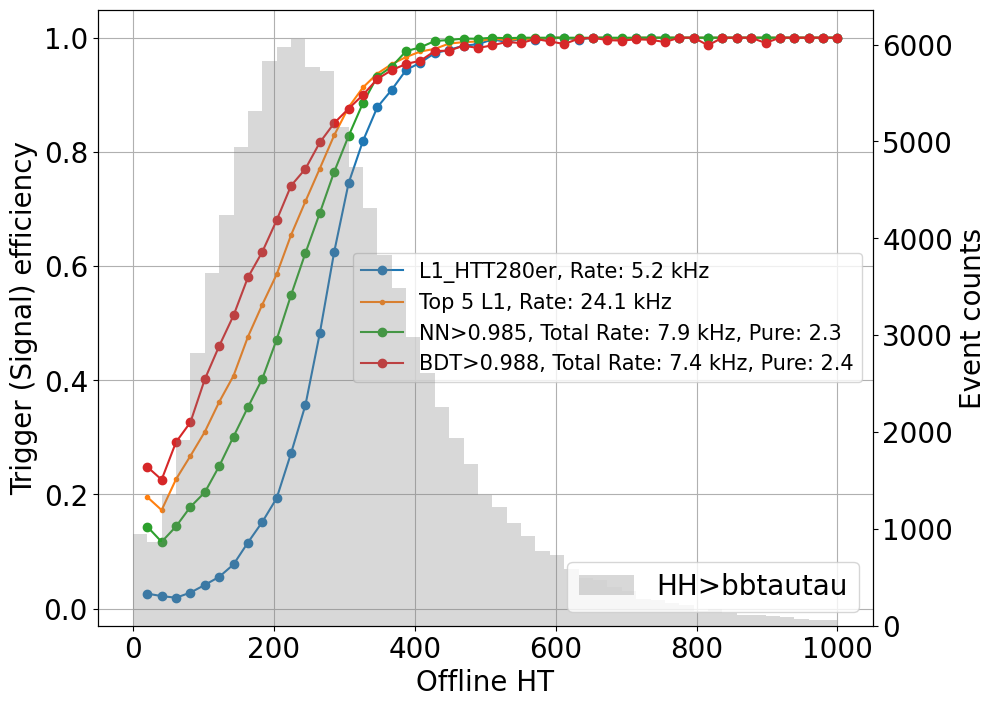

In [99]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("Offline HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr) 
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# BDT trigger
for thr in [0.988]:
    trig_mask = (y_bdt > thr) 
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "BDT>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))



# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)

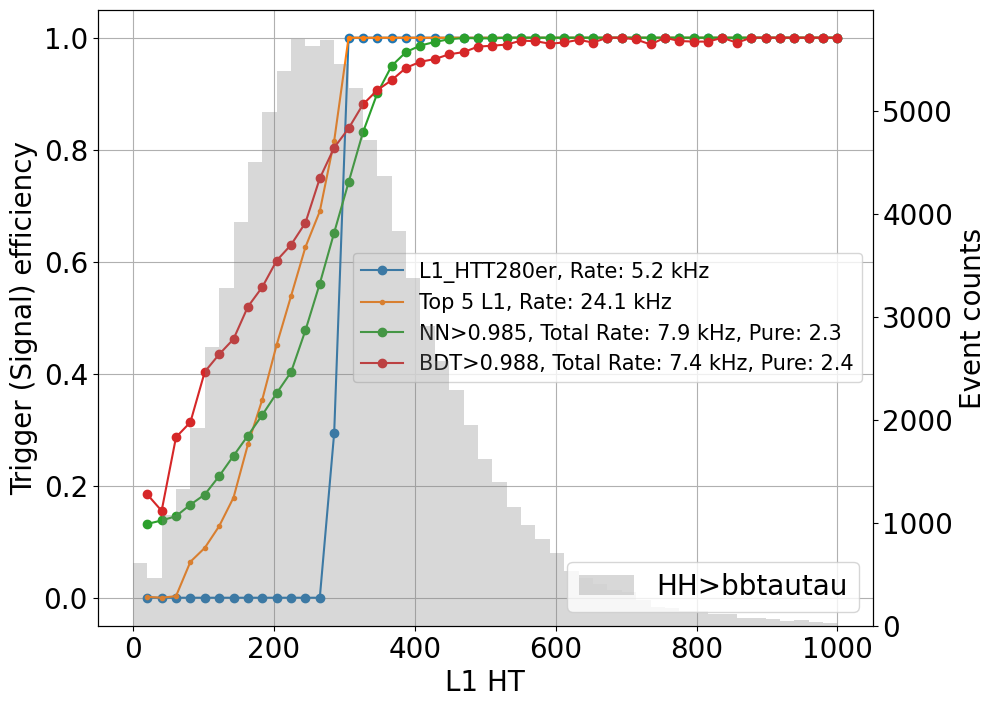

In [100]:
f,ax1 = plt.subplots(figsize = (10,8))
ax2 = ax1.twinx()
ax1.set_xlabel("L1 HT")
ax1.set_ylabel("Trigger (Signal) efficiency")

xvar = l1ht_sig
xbins = np.linspace(0,1000,50)
den = np.histogram(xvar, bins = xbins)
ax2.hist(xvar, bins = xbins, label = "HH>bbtautau", color = "grey", alpha = 0.3)
ax2.legend(loc = 4)
ax2.set_ylabel("Event counts")

#### L1 
for trig in list(best_trigs[:1]):# + ["L1_SingleJet180"]:
    num = np.histogram(xvar[bits_sig[trig]], bins = den[1])
    rate = np.sum(bits_bkg[trig]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = f"{trig}, Rate: {rate:.1f} kHz")
    
## BEST 5
if True:
    num = np.histogram(xvar[best_bits_or[y==1]], bins = den[1])
    rate = np.sum(best_bits_or[y==0]) / len(y_bkg) * totalMinBiasRate()
    ax1.plot(den[1][1:], num[0]/den[0], ".-", label = f"Top 5 L1, Rate: {rate:.1f} kHz")

## NN trigger
for thr in [0.985]:
    trig_mask = (y_pred > thr) #& (l1ht_all > 150)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "NN>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))

# BDT trigger
for thr in [0.988]:
    trig_mask = (y_bdt > thr) #& (l1ht_all > 150)
    num = np.histogram(xvar[trig_mask[y == 1]], bins = den[1])

    rate = np.sum(trig_mask[y == 0])/ len(y_bkg) * totalMinBiasRate()
    pure_rate = np.sum(trig_mask[y == 0] & ~all_trig_or[y==0])/ len(y_bkg) * totalMinBiasRate()
    
    ax1.plot(den[1][1:], num[0]/den[0], "o-", label = "BDT>%s, Total Rate: %.1f kHz, Pure: %.1f" %(thr, rate, pure_rate))


# ax1.set_ylim(0,1.2)
ax1.grid()

ax1.legend(loc = 5, fontsize = 15)